In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy import stats
import random
from scipy.stats import pearsonr, spearmanr, kendalltau
import pingouin as pg #compute repeated measure correlation
import collections #sorted dictionarries
from itertools import combinations

#save and load dictionaries/lists
import pickle

#plot
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

C:\Users\camil\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\camil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\camil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import kmeans_clustering, ZoneVariable, time_series_henColumn_tsRow, FB_daily, corr_from_dep2feature,FB_process,\
corr_from_feature2feature, correlationGraph, ZoneVariable, DataRepresentation1, sampen, chi2_distance, is_day, correct_key
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
C:\Users\camil\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\camil\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\camil\anaconda3\lib\site-packages\gensim\matutils.py:24: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  fro

2


# Define parameters

In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
id_run = config.id_run
dico_pen_tr = config.dico_pen_tr
dico_HAID_date = config.dico_HAID_date
birth_date = config.birth_date
dico_night_hour = config.dico_night_hour
date_consistent_barn_schedule = config.date_consistent_barn_schedule
path_extracted_data_chapter2 = os.path.join(path_extracted_data,'chapter2')
#create a director if not existing
if not os.path.exists(path_extracted_data_chapter2):
    os.makedirs(path_extracted_data_chapter2)

change the configuration file if not done yet!


# Download variables

In [4]:
#weather conditions
path_weather = os.path.join(r'G:\VPHI\Welfare\2- Research Projects\OFHE2.OriginsE2\DataOutput','Weather_process.csv')
df_weather_h = pd.read_csv(path_weather, sep=';', parse_dates=['date','Timestamp'])
df_weather_h = df_weather_h.sort_values('Timestamp') 
df_weather_h = df_weather_h.drop(['date'], axis=1)
df_weather_h['Timestamp_weather'] = df_weather_h['Timestamp'].copy()
print(df_weather_h.shape)
display(df_weather_h.head(3))

(7293, 13)


,Timestamp,temperature,humidity,wind speed,Precipitation amount,query,Moon Phase calculator,hour,temperature_C,wind_speed_mpers,humidity_avgpercent,rain,Timestamp_weather
0,2020-09-29 00:00:00,"10 °C\n(12:00 am CEST | Tuesday, September 29,...",average: 100% (100%)\n(12:00 am CEST | Tuesday...,"2 m/s\n(12:00 am CEST | Tuesday, September 29,...","rain\n(12:00 am CEST | Tuesday, September 29, ...","Moon Phase calculatorSeptember 29, 2020 0h",| waxing gibbous moon\n91.87% illuminated,0,10,2,100,rain,2020-09-29 00:00:00
1,2020-09-29 01:00:00,"10 °C\n(1:00 am CEST | Tuesday, September 29, ...","average: 100% (100%)\n(1:00 am CEST | Tuesday,...","3 m/s\n(1:00 am CEST | Tuesday, September 29, ...","rain\n(1:00 am CEST | Tuesday, September 29, 2...","Moon Phase calculatorSeptember 29, 2020 1h",| waxing gibbous moon\n92.09% illuminated,1,10,3,100,rain,2020-09-29 01:00:00
2,2020-09-29 02:00:00,"10 °C\n(2:00 am CEST | Tuesday, September 29, ...","average: 100% (100%)\n(2:00 am CEST | Tuesday,...","3 m/s\n(2:00 am CEST | Tuesday, September 29, ...","rain\n(2:00 am CEST | Tuesday, September 29, 2...","Moon Phase calculatorSeptember 29, 2020 2h",| waxing gibbous moon\n92.30% illuminated,2,10,3,100,rain,2020-09-29 02:00:00


In [5]:
#focal birds information (one row per focal bird)
df_FB = pd.read_csv(os.path.join(path_extracted_data, id_run+'df_FOCALBIRDS.csv'), sep=';',
                    parse_dates=['InitialStartDate'], dayfirst=True)
print(df_FB.shape)
df_FB.head(3)

(232, 14)


,HenID,PenID,CLASS,R-Pen,InitialStartDate,early_death,29-09 weight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,weight 12-04-21,weight 26-07-21,Treatment
0,hen_1,9,EPI,1.0,2020-06-10,0.0,1134.0,57.0,1696.5,1787.8,1800.9,NaN,NaN,OFH
1,hen_10,11,LEXP,1.0,2020-06-10,0.0,1070.0,70.4,1488.3,1628.4,1602.1,1587.2,1713.4,OFH
2,hen_100,5,EPI,3.0,2020-06-10,0.0,1182.0,80.5,1642.5,NaN,NaN,NaN,NaN,OFH


In [6]:
#KBF&severity
df_HA = pd.read_csv(os.path.join(path_extracted_data, 'df_all_HA.csv'), sep=';', parse_dates=['date'], dayfirst=True) 
df_HA['FeatherDamage'] = df_HA['Feathers'].map(lambda x: 100-x)
df_HA['date_HA'] = df_HA['date'].copy()
print(df_HA.shape)
#display(df_HA.groupby(['HAID'])['date'].agg(lambda x: set(x)).reset_index())
display(df_HA['HAID'].value_counts())
#info on date
display(df_HA.groupby(['HAID','date','WOA','DOA'])['HenID'].count().reset_index())
print(df_HA.shape)
df_HA.head(3)

(846, 60)


HA1    176
HA3    176
HA4    176
HA2    160
HA5    158
Name: HAID, dtype: int64

,HAID,date,WOA,DOA,HenID
0,HA1,2020-11-23,25.0,173.0,175
1,HA2,2021-01-04,31.0,215.0,160
2,HA3,2021-02-01,35.0,243.0,176
3,HA4,2021-04-12,45.0,313.0,176
4,HA5,2021-07-25,60.0,417.0,157


(846, 60)


,Person_toe,Time,PenID,FocalLegringName,BirdType,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,random_order1,severity,has_gap,BirdID,uncertainty (0:certain:1 random),Unnamed: 9,Info,backpack,FeatherDamage,date_HA
0,M,09:30,pen9,42grey,normal,25.0,NaN,0.0,0.0,0.0,...,109.0,0,0.0,42grey9sb,NaN,NaN,"['', '42', 'grey', '9', 'sb']",sb,NaN,2020-11-23
1,Mark,14:54,pen9,66grey,normal,0.0,NaN,50.0,0.0,0.0,...,509.0,16,0.0,66grey9sp,NaN,NaN,"['', '66', 'grey', '9', 'sp']",sp,14.0,2021-02-01
2,Camille,10:30,pen5,2green,normal,130.0,NaN,25.0,0.0,0.0,...,428.0,4,0.0,2green5pp,NaN,NaN,"['', '2', 'green', '5', 'pp']",pp,8.0,2021-02-01


In [7]:
#daily variables of the movements (one row per available hen per day)
df_daily = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_verified.csv'), sep=';',
                     parse_dates=['level'], dayfirst=True)
print(df_daily.shape)
#removing days with closed WG (removing two vaccinations date)
df_daily = df_daily[~df_daily['level'].isin(list(config.close_dates))]
print(df_daily.shape)
df_daily['vaccination_day'] = df_daily['level'].map(lambda x: config.dico_vaccinationDate_type.get(x,'No vaccination'))
display(df_daily['vaccination_day'].value_counts())
df_daily['time_wg_open_h'] = df_daily['time_wg_open_sec'].map(lambda x: x/60/60)
print('went in WG yes/no:')
display(df_daily['WentinWG'].value_counts(normalize=True))
#after stabilising egg laying & maagement schedule
df_daily = df_daily[df_daily['level']>dt.datetime(2020,11,24)]#not the day after HA
dico_cl = {'MEXP':'MEXP','LEXP':'LEXP',
           'EPI':'REXP','LEXPLOST':'REXP','MEXPLOST':'REXP','NewAfterEpi':'REXP','NewAfterEpiLOST':'REXP'}
df_daily['CLASS'] = df_daily['CLASS'].map(lambda x: dico_cl[x])
display(df_daily['CLASS'].value_counts())
print('number of hen per class:')
display(df_daily.groupby(['CLASS'])['HenID'].agg(lambda x: len(set(x))))
#lets keep only the one selected randomly, and remove the one selected thorugh CLASS; as it did not worked well
#df_daily = df_daily[df_daily['CLASS']=='REXP']
#because we need the nights as well, lets remove all observations when the nights are ot workig
print(df_daily.shape)    
df_daily = df_daily[~df_daily['night_level'].isnull()]
print(df_daily.shape)    

if df_daily[df_daily.isna().any(axis=1)].shape[0]>0:
    print('YOU HAVE SOME NAN:')
    display(df_daily.isna().sum(axis=0).sort_values().tail(15))
    print(df_daily[df_daily.isna().any(axis=1)].shape)
print(df_daily.shape)    
df_daily.head(3)

(39382, 82)
(38625, 82)


No vaccination    37840
IBMa5Nobilis        471
IB4/91Nobilis       158
Ecoli               156
Name: vaccination_day, dtype: int64

went in WG yes/no:


1    0.644324
0    0.355676
Name: WentinWG, dtype: float64

REXP    18095
MEXP     7164
LEXP     5817
Name: CLASS, dtype: int64

number of hen per class:


CLASS
LEXP     30
MEXP     38
REXP    126
Name: HenID, dtype: int64

(31076, 84)
(30780, 84)
YOU HAVE SOME NAN:


time_wg_open_sec                 0
perc_duration_1_Zone             0
FirstTimestamp_4_Zone           13
mid_cum_Z4_sec                  13
weight_interp                   97
KBF_interp                      97
mid_cum_Z4_h_Morning           120
mid_cum_Z4_sec_Morning         120
FirstTimestamp_3_Zone          143
FirstTimestamp_2_Zone          181
FeatherDamage_interp           272
FirstTimestamp_5_Zone         1013
FirstTimestamp_1_Zone         9847
FirstTimestamp_1_Zone_sec     9847
R-Pen                        10081
dtype: int64

(17652, 84)
(30780, 84)


,HenID,level,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone,perc_duration_2_Zone,perc_duration_1_Zone,...,food_sameDurTiming_r50_AP_final,food_sameDurTiming_r50_AB_final,duration_1_Zone_min,duration_2_Zone_min,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min,Has_been_toptier_wholeday,vaccination_day,time_wg_open_h
53,hen_131,2020-11-25,54000.0,15.0,"[654.0, 24673.0, 15720.0, 3219.0, 9734.0]",29.0,6.0,18.0,46.0,1.0,...,-0.20,0.64,10.900000,411.216667,262.000000,53.650000,162.233333,False,No vaccination,6.250000
54,hen_131,2020-11-26,54000.0,15.0,"[280.0, 27891.0, 20572.0, 1632.0, 3625.0]",38.0,3.0,7.0,52.0,1.0,...,0.03,0.48,4.666667,464.850000,342.866667,27.200000,60.416667,False,No vaccination,6.500000
55,hen_131,2020-11-27,54000.0,15.0,"[1397.0, 23308.0, 15043.0, 3902.0, 10350.0]",28.0,7.0,19.0,43.0,3.0,...,-0.26,0.15,23.283333,388.466667,250.716667,65.033333,172.500000,False,No vaccination,6.333333


# Validate Fresh food experience index

In [8]:
def plot_food(df, food_index, food_index_rp, food_index_rm, name_):
    df_plt = pd.melt(df, id_vars=['HenID','level','PenID'], 
            value_vars=[food_index,food_index_rp,food_index_rm],
            value_name='food_behavior')
    df_plt['is_positive'] = df_plt['food_behavior'].map(lambda x: int(x>0))
    display(df_plt.head(3))
    df_plt_ = df_plt.groupby(['variable','level'])['is_positive'].agg(lambda x: sum(x)/len(x)*100).reset_index()
    display(df_plt_.head(3))
    display(df_plt_.groupby(['variable']).agg(mean_is_positive=pd.NamedAgg(column='is_positive', aggfunc=lambda x: np.nanmean(x)),
               sd_is_positive=pd.NamedAgg(column='is_positive', aggfunc=lambda x: np.std(x))).reset_index())
    #weekly average +-SD of the mean daily food-related behavior across individuals
    plt.figure(figsize=(10,3))
    pal_ = {food_index_rm:'darkorange', food_index_rp:'indianred', food_index:'steelblue'}
    sns.histplot(df_plt, x='food_behavior', kde=True, hue='variable', palette=pal_, bins=50);
    plt.ylabel('')
    plt.xlabel('')
    plt.title('density')
    plt.axvline(0, color='black');
    plt.savefig(os.path.join(path_extracted_data, 'BS_FOODANALYSIS__FoodRI_density_'+name_+'.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show()

    ########################################################################################################################
    plt.figure(figsize=(30,9))
    sns.pointplot(y=food_index, x='DIB', color=pal_[food_index], data=df, 
                  estimator=np.median);
    sns.pointplot(y=food_index_rm, x='DIB', color=pal_[food_index_rm], data=df, 
                  estimator=np.median);
    sns.pointplot(y=food_index_rp, x='DIB', color=pal_[food_index_rp], data=df, 
                  estimator=np.median);
    plt.axhline(y=0, linewidth=2, color = 'k')
    plt.ylim((-0.15, 0.45))
    plt.title('daily mean estimates over time')
    plt.xticks([])
    plt.ylabel('')
    plt.xlabel('')
    plt.grid()
    plt.savefig(os.path.join(path_extracted_data, 'BS_FOODANALYSIS__FoodRI_overtime_mean_'+name_+'.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show()

    ########################################################################################################################
    l=1
    c=3
    fig = plt.figure(figsize=(10,3)) #/100 si trop grand nbr
    df_plt = df.groupby(['HenID']).mean().reset_index()

    plt.subplot(l,c,1)
    sns.scatterplot(data=df_plt, x='vertical_travel_distance_fulllight_perinsideh', y=food_index_rm,
                    color=pal_[food_index_rm])#,  size="size", sizes=(20, 200))
    plt.ylabel('')
    #plt.title('food reactivity index backward push')
    plt.xlabel('')
    plt.yticks(fontsize=10)
    plt.ylim((-0.8, 0.8))


    plt.subplot(l,c,2)
    sns.scatterplot(data=df_plt, x='vertical_travel_distance_fulllight_perinsideh', y=food_index,
                    color=pal_[food_index])#,  size="size", sizes=(20, 200))
    plt.xlabel('vertical travelled distance during full light (/h)', size=13)
    plt.ylabel('')
    #plt.title('food reactivity index')
    plt.ylim((-0.8, 0.8))

    plt.subplot(l,c,3)
    sns.scatterplot(data=df_plt, x='vertical_travel_distance_fulllight_perinsideh', y=food_index_rp,
                    color=pal_[food_index_rp])#,  size="size", sizes=(20, 200))
    plt.ylabel('')
    #plt.title('hens\' mean value')
    plt.xlabel('')
    plt.ylim((-0.8, 0.8))
    plt.savefig(os.path.join(path_extracted_data,'BS_FOODANALYSIS_Raw_VTD_food_'+name_+'.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show();

,HenID,level,PenID,variable,food_behavior,is_positive
0,hen_131,2020-11-25,pen10,food_related_behavior_final,0.234032,1
1,hen_131,2020-11-26,pen10,food_related_behavior_final,0.114246,1
2,hen_131,2020-11-27,pen10,food_related_behavior_final,0.165864,1


,variable,level,is_positive
0,food_related_behavior_final,2020-11-25,78.343949
1,food_related_behavior_final,2020-11-26,78.980892
2,food_related_behavior_final,2020-11-27,74.522293


,variable,mean_is_positive,sd_is_positive
0,food_related_behavior_final,76.666758,3.818673
1,food_related_behavior_rm_final,52.546251,6.426403
2,food_related_behavior_rp_final,53.986416,4.572016


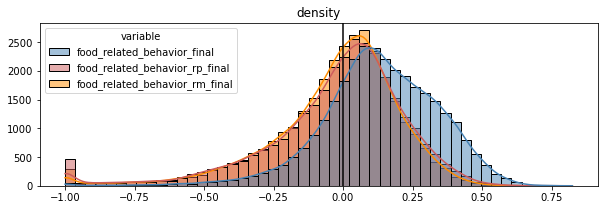

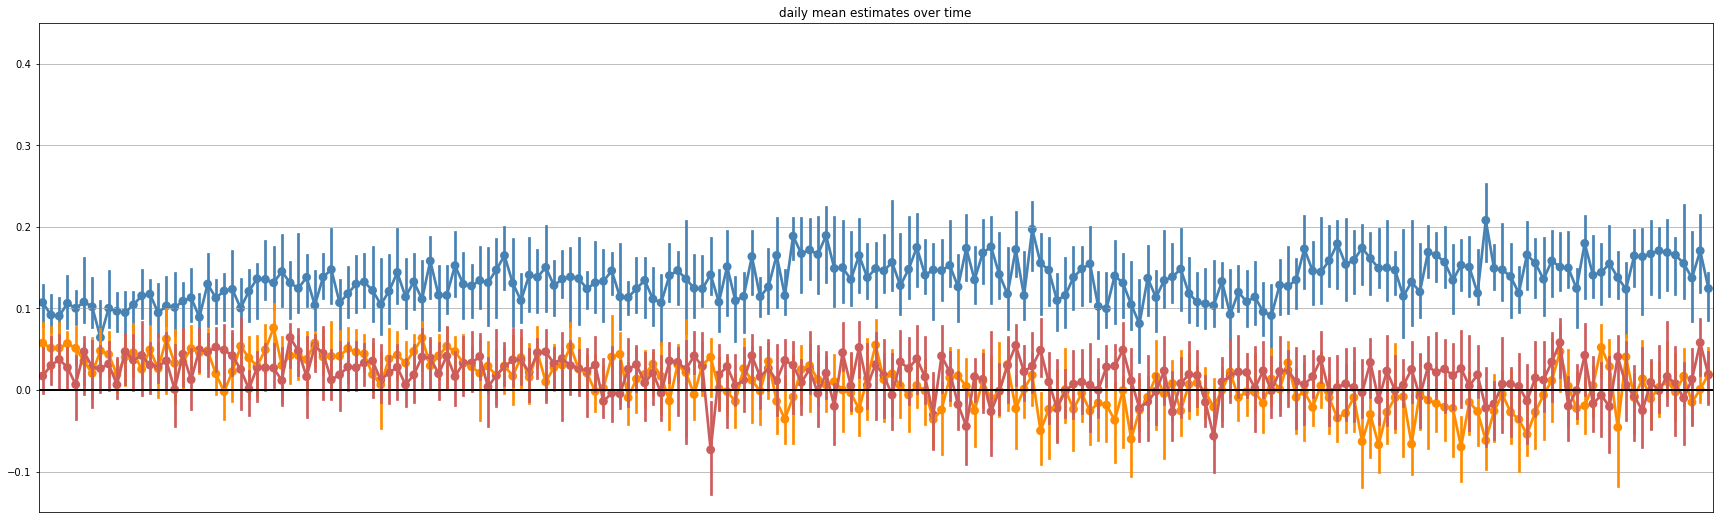

C:\Users\camil\AppData\Local\Temp/ipykernel_14904/3003793707.py:44: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_plt = df.groupby(['HenID']).mean().reset_index()


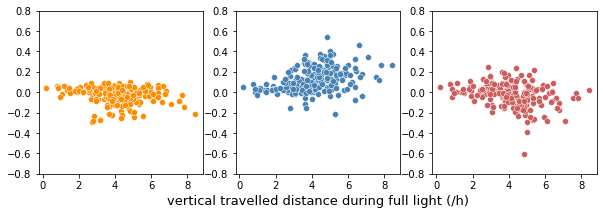

,HenID,level,PenID,variable,food_behavior,is_positive
0,hen_131,2020-11-25,pen10,food_sameDurTiming_r50_final,0.55,1
1,hen_131,2020-11-26,pen10,food_sameDurTiming_r50_final,0.36,1
2,hen_131,2020-11-27,pen10,food_sameDurTiming_r50_final,0.46,1


,variable,level,is_positive
0,food_sameDurTiming_r50_AB_final,2020-11-25,54.777070
1,food_sameDurTiming_r50_AB_final,2020-11-26,62.420382
2,food_sameDurTiming_r50_AB_final,2020-11-27,61.146497


,variable,mean_is_positive,sd_is_positive
0,food_sameDurTiming_r50_AB_final,52.595012,4.790707
1,food_sameDurTiming_r50_AP_final,52.268991,4.377365
2,food_sameDurTiming_r50_final,77.490145,3.662011


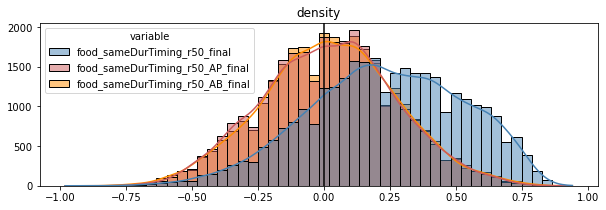

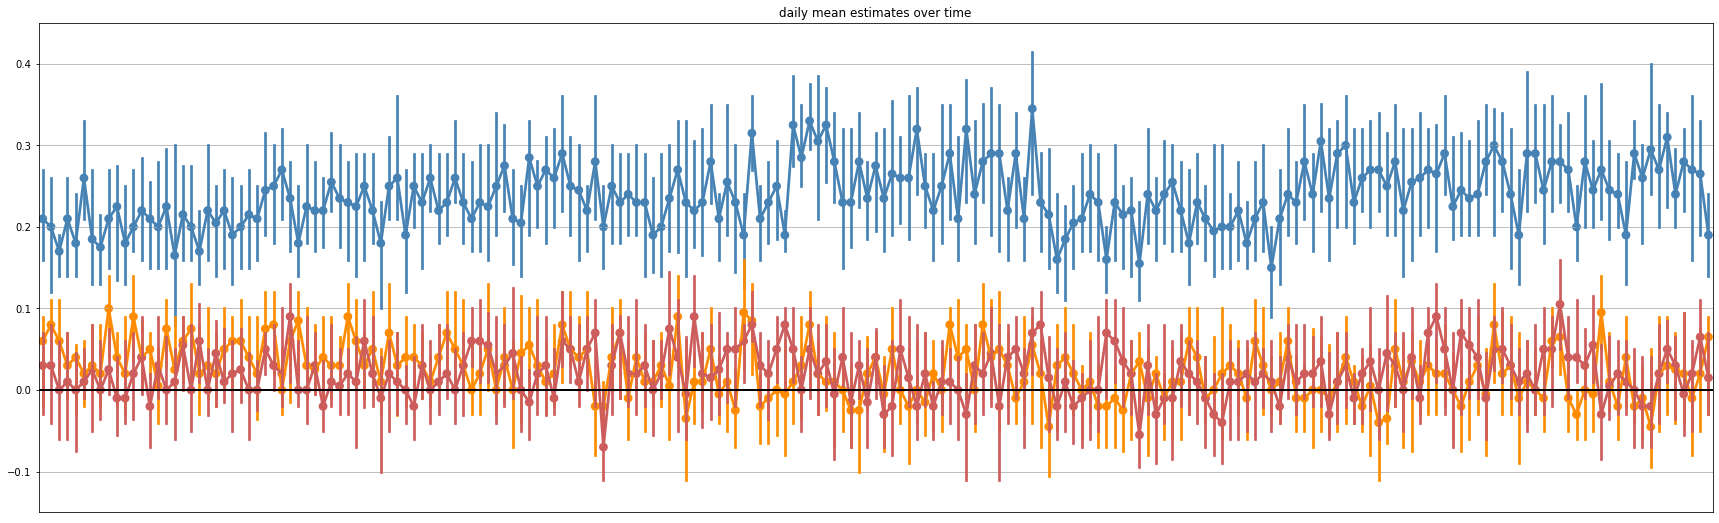

C:\Users\camil\AppData\Local\Temp/ipykernel_14904/3003793707.py:44: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_plt = df.groupby(['HenID']).mean().reset_index()


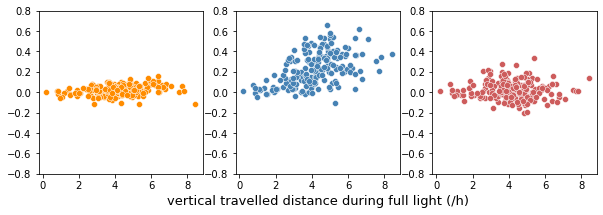

In [9]:
plot_food(df=df_daily, food_index = 'food_related_behavior_final', food_index_rp = 'food_related_behavior_rp_final', 
          food_index_rm = 'food_related_behavior_rm_final', name_ = 'V1')

plot_food(df=df_daily, food_index = 'food_sameDurTiming_r50_final', food_index_rp = 'food_sameDurTiming_r50_AP_final', 
          food_index_rm = 'food_sameDurTiming_r50_AB_final', name_ = 'V2')

# Info on selection process

In [10]:
#when possible (i.e. enough MEXP in each pens), 25% (resp.25%) of focal bird were selected randomly among the MEXP (resp. LEXP) 
#remaining 50% of focal animals were selected as a representative sample of the population (called here EPI, as part of a larger study
#with epigenetics analysis)
print(df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12), dt.datetime(2020,9,29)])].shape)
print(df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].shape)
df_info = df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].groupby(['Treatment','R-Pen','CLASS'])['HenID'].count().reset_index()
print(df_info.shape)
df_info

(160, 14)
(150, 14)
(12, 4)


,Treatment,R-Pen,CLASS,HenID
0,OFH,1.0,EPI,20
1,OFH,1.0,LEXP,9
2,OFH,1.0,MEXP,10
3,OFH,3.0,EPI,20
4,OFH,3.0,LEXP,8
5,OFH,3.0,MEXP,9
6,TRAN,2.0,EPI,21
7,TRAN,2.0,LEXP,10
8,TRAN,2.0,MEXP,6
9,TRAN,4.0,EPI,19


In [11]:
#repartition of Rearing pen in laying pen across class
print(df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12), dt.datetime(2020,9,29)])].shape)
print(df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].shape)
df_info = df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].groupby(['Treatment','R-Pen','CLASS',
                                                                                                 'PenID'])['HenID'].count().reset_index()
print(df_info.shape)
df_info

(160, 14)
(150, 14)
(47, 5)


,Treatment,R-Pen,CLASS,PenID,HenID
0,OFH,1.0,EPI,3,5
1,OFH,1.0,EPI,5,5
2,OFH,1.0,EPI,9,5
3,OFH,1.0,EPI,11,5
4,OFH,1.0,LEXP,3,2
5,OFH,1.0,LEXP,5,3
6,OFH,1.0,LEXP,9,2
7,OFH,1.0,LEXP,11,2
8,OFH,1.0,MEXP,3,3
9,OFH,1.0,MEXP,5,2


In [12]:
#repartition of class in laying pen
df_info = df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].groupby(['Treatment','PenID','CLASS'])['HenID'].count().reset_index()
print(df_info.shape)
df_info

(24, 4)


,Treatment,PenID,CLASS,HenID
0,OFH,3,EPI,10
1,OFH,3,LEXP,5
2,OFH,3,MEXP,5
3,OFH,5,EPI,10
4,OFH,5,LEXP,4
5,OFH,5,MEXP,5
6,OFH,9,EPI,10
7,OFH,9,LEXP,5
8,OFH,9,MEXP,5
9,OFH,11,EPI,10


In [13]:
#uniform representation of rearing pen identity (RPenID) in each LPenID
df_info = df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].groupby(['PenID','R-Pen'])['HenID'].count().reset_index()
print(df_info.shape)
df_info

(16, 3)


,PenID,R-Pen,HenID
0,3,1.0,10
1,3,3.0,10
2,4,2.0,9
3,4,4.0,9
4,5,1.0,10
5,5,3.0,9
6,8,2.0,9
7,8,4.0,8
8,9,1.0,10
9,9,3.0,10


# Visual over time of 5 mvt metrics

Series([], Name: PenID, dtype: int64)

Series([], Name: PenID, dtype: int64)

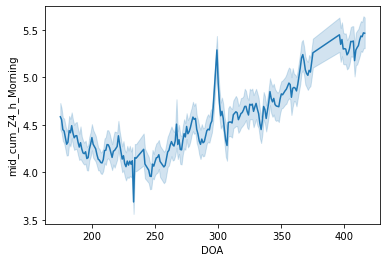

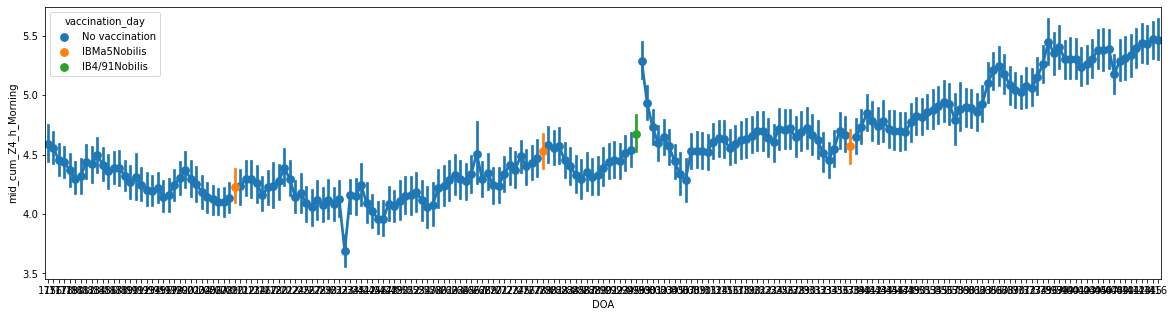

In [14]:
sns.lineplot(y='mid_cum_Z4_h_Morning', x='DOA', data=df_daily);
#pick: display(df_daily[df_daily['DOA']==219][['level','PenID','HenID','mid_cum_Z4_h_Morning']].head(25))
#2021,1,8: dont know why. Because mini marker pen 3-5 did not worked on that day, maybe something else went wrong 
#that we did not detected, so I removed it
display(df_daily[df_daily['DOA']==219]['PenID'].value_counts())
df_daily = df_daily[df_daily['DOA']!=219]
plt.figure(figsize=(20,5))
df_daily = df_daily[df_daily['DOA']!=219]
sns.pointplot(y='mid_cum_Z4_h_Morning', x='DOA', hue='vaccination_day', data=df_daily);
#the peack: display(df_daily[df_daily['DOA']==219][['level','PenID','HenID','mid_cum_Z4_h_Morning']].head(25))
#2021,1,8: dont know why. mini marker pen 3-5 did not worked so maybe something else too? should i remove it?
df_daily[df_daily['DOA']==219]['PenID'].value_counts()
#sns.scatterplot(y='mid_cum_Z4_h_Morning', x='DOA', color='red', data=df_daily[df_daily['vaccination_day']]);

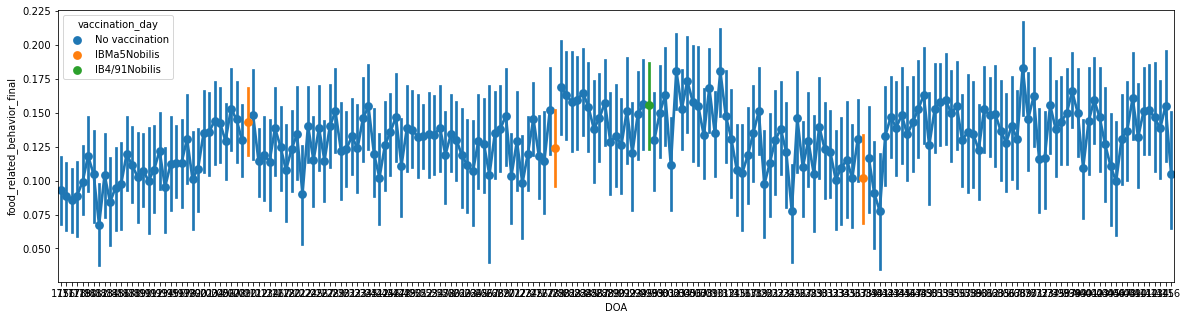

In [15]:
plt.figure(figsize=(20,5))
sns.pointplot(y='food_related_behavior_final', x='DOA', hue='vaccination_day', data=df_daily);

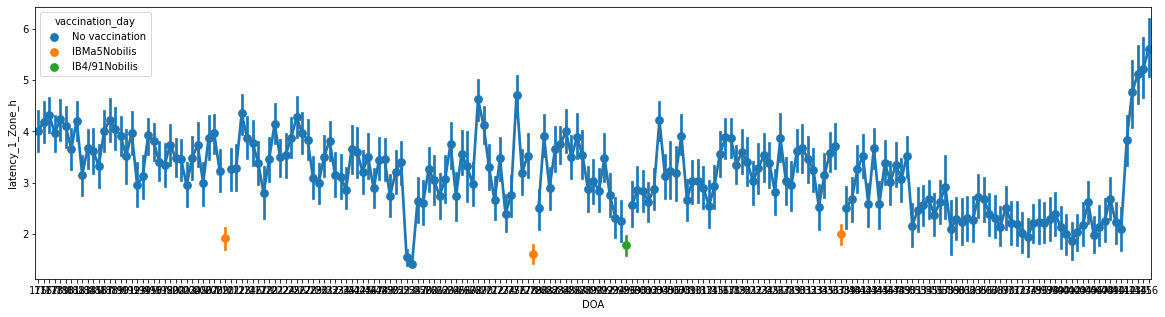

In [16]:
plt.figure(figsize=(20,5))
sns.pointplot(y='latency_1_Zone_h', x='DOA', hue='vaccination_day', data=df_daily);

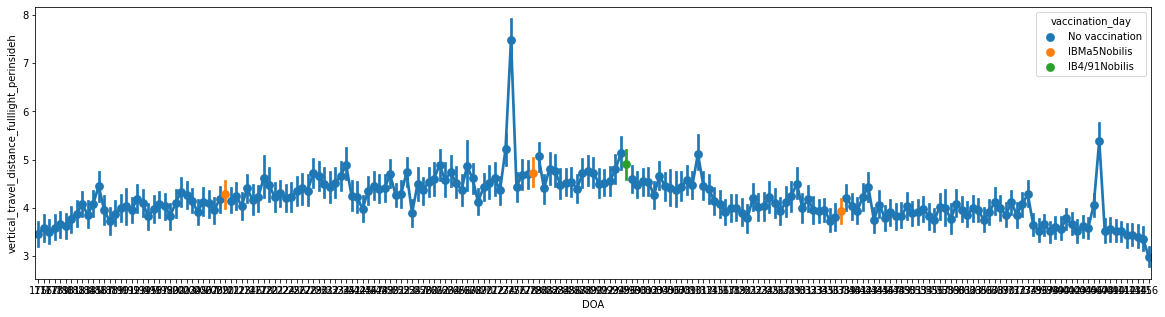

In [17]:
plt.figure(figsize=(20,5))
sns.pointplot(y='vertical_travel_distance_fulllight_perinsideh', x='DOA', hue='vaccination_day', data=df_daily);

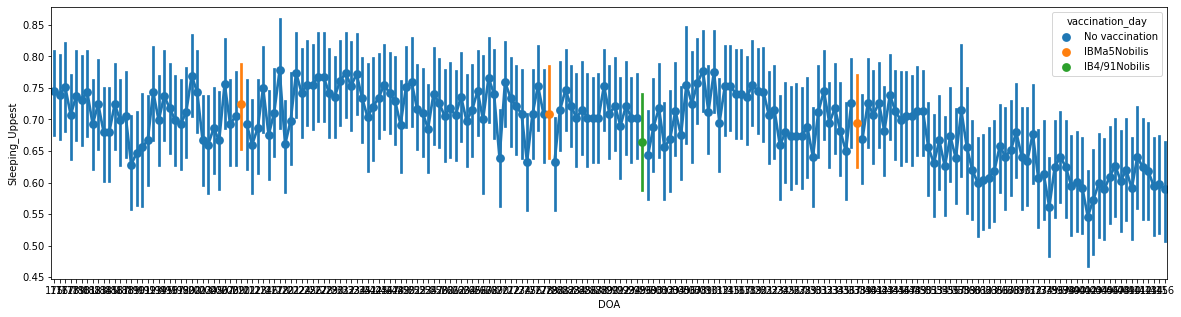

In [18]:
plt.figure(figsize=(20,5))
sns.pointplot(y='Sleeping_Uppest', x='DOA', hue='vaccination_day', data=df_daily);

# Add external temperature as environmental factor

In [19]:
#check variation over the day... exist very much
df_weather_h['date'] = df_weather_h['Timestamp'].map(lambda x: dt.datetime.date(x))
df_wday = df_weather_h[df_weather_h['hour'].isin([11,12,13,14,15,16])].groupby(['date'])['temperature_C'].agg(lambda x: list(x)).reset_index()
df_wday['temperature_C_avg'] = df_wday['temperature_C'].map(lambda x: np.mean(x))
display(df_wday.head(3))
#display(df_wday[df_wday['date']>=dt.date(2021,7,1)])

print(df_daily.shape)
df_daily['date'] = df_daily['level'].map(lambda x: dt.datetime.date(x))
df_daily = pd.merge(df_daily, df_wday, on='date', how='left')
print(df_daily.shape)
df_daily.head(2)

,date,temperature_C,temperature_C_avg
0,2020-09-29,"[11, 12, 12, 12, 12, 13]",12.0
1,2020-09-30,"[10, 11, 13, 13, 14, 14]",12.5
2,2020-10-01,"[13, 15, 15, 15, 15, 14]",14.5


(30780, 84)
(30780, 87)


,HenID,level,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone,perc_duration_2_Zone,perc_duration_1_Zone,...,duration_2_Zone_min,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min,Has_been_toptier_wholeday,vaccination_day,time_wg_open_h,date,temperature_C,temperature_C_avg
0,hen_131,2020-11-25,54000.0,15.0,"[654.0, 24673.0, 15720.0, 3219.0, 9734.0]",29.0,6.0,18.0,46.0,1.0,...,411.216667,262.000000,53.65,162.233333,False,No vaccination,6.25,2020-11-25,"[0, 1, 2, 2, 2, 2]",1.500000
1,hen_131,2020-11-26,54000.0,15.0,"[280.0, 27891.0, 20572.0, 1632.0, 3625.0]",38.0,3.0,7.0,52.0,1.0,...,464.850000,342.866667,27.20,60.416667,False,No vaccination,6.50,2020-11-26,"[1, 3, 4, 4, 4, 3]",3.166667


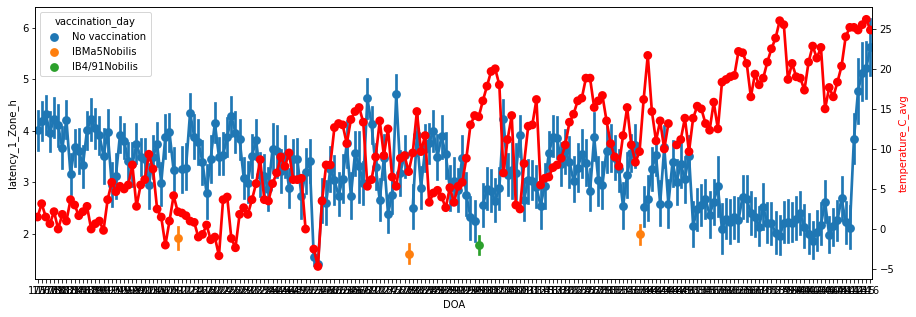

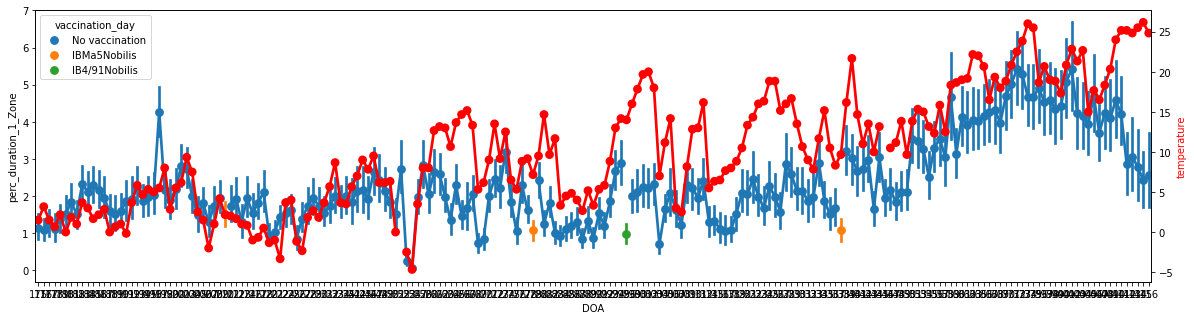

In [20]:
plt.figure(figsize=(15,5))
sns.pointplot(y='latency_1_Zone_h', x='DOA', hue='vaccination_day', size=0.3, alpha=0.4, data=df_daily);
ax2 = plt.twinx()
sns.pointplot(y='temperature_C_avg', x='DOA', color='red', size=0.3, alpha=0.4, data=df_daily, ax=ax2);
plt.ylabel("temperature_C_avg", color='red');
plt.show()

plt.figure(figsize=(20,5))
sns.pointplot(y='perc_duration_1_Zone', x='DOA', hue='vaccination_day', size=0.3, alpha=0.4, data=df_daily);
ax2 = plt.twinx()
sns.pointplot(y='temperature_C_avg', x='DOA', size=0.3,color='red', alpha=0.4, data=df_daily, ax=ax2);
plt.ylabel("temperature", color='red');

# Save weekly mvt for behavioural syndrome

In [21]:
#df_daily[['HenID','level','latency_1_Zone_h','time_wg_open_h','perc_1_Zone_while_WG_open','duration_1_Zone_min','WentinWG']].head(3)

# Numbers on the full available dataset

In [22]:
mi = min(df_daily['DOA'].tolist())
ma = max(df_daily['DOA'].tolist())
print('We are involving a period of %d days (%.2f months) of tracking during the days from the DOA %d until DOA %d'%(ma-mi+1, (ma-mi+1)/30.4,mi, ma))

mi = min(df_daily['WOA'].tolist())
ma = max(df_daily['WOA'].tolist())
print('We are involving a period of %d weeks of tracking during the days from the WOA %d until WOA %d'%(ma-mi+1, mi, ma))

df_info = df_daily.groupby(['HenID'])['DOA','level','PenID'].agg(lambda x: list(x)).reset_index()
df_info['nbrDaysTracked'] = df_info['DOA'].map(lambda x: len(set(x)))
df_info = df_info.sort_values(['nbrDaysTracked'])
display(df_info.head(3))
display(df_info.tail(3))
#pen 5 had issues with batteries of markers!
display(df_info['nbrDaysTracked'].mean())

print('Hens had in average %d days tracked with a minimum of %d days tracked and a maximum of %d days tracked.'%(round(df_info['nbrDaysTracked'].mean(),0),
                                                                                df_info['nbrDaysTracked'].min(),  
                                                                                df_info['nbrDaysTracked'].max()))
print('In other words, %d hens were used in subsequent analysis with a total of %d observations.'%(len(df_daily['HenID'].unique()),
                                                                                                   df_daily.shape[0]))

We are involving a period of 242 days (7.96 months) of tracking during the days from the DOA 175 until DOA 416
We are involving a period of 36 weeks of tracking during the days from the WOA 25 until WOA 60


C:\Users\camil\AppData\Local\Temp/ipykernel_14904/2085912283.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_info = df_daily.groupby(['HenID'])['DOA','level','PenID'].agg(lambda x: list(x)).reset_index()


,HenID,DOA,level,PenID,nbrDaysTracked
106,hen_213,"[245, 246, 247, 248, 249, 250, 251, 252, 253, ...","[2021-02-03 00:00:00, 2021-02-04 00:00:00, 202...","[pen8, pen8, pen8, pen8, pen8, pen8, pen8, pen...",12
112,hen_219,"[315, 316, 317, 318, 319, 320, 321, 325, 328, ...","[2021-04-14 00:00:00, 2021-04-15 00:00:00, 202...","[pen10, pen10, pen10, pen10, pen10, pen10, pen...",41
0,hen_1,"[175, 176, 177, 178, 179, 180, 181, 182, 183, ...","[2020-11-25 00:00:00, 2020-11-26 00:00:00, 202...","[pen9, pen9, pen9, pen9, pen9, pen9, pen9, pen...",57


,HenID,DOA,level,PenID,nbrDaysTracked
15,hen_119,"[175, 176, 177, 178, 179, 180, 181, 182, 183, ...","[2020-11-25 00:00:00, 2020-11-26 00:00:00, 202...","[pen5, pen5, pen5, pen5, pen5, pen5, pen5, pen...",200
57,hen_167,"[175, 176, 177, 178, 179, 180, 181, 182, 183, ...","[2020-11-25 00:00:00, 2020-11-26 00:00:00, 202...","[pen5, pen5, pen5, pen5, pen5, pen5, pen5, pen...",200
130,hen_25,"[175, 176, 177, 178, 179, 180, 181, 182, 183, ...","[2020-11-25 00:00:00, 2020-11-26 00:00:00, 202...","[pen3, pen3, pen3, pen3, pen3, pen3, pen3, pen...",200


158.659793814433

Hens had in average 159 days tracked with a minimum of 12 days tracked and a maximum of 200 days tracked.
In other words, 194 hens were used in subsequent analysis with a total of 30780 observations.


In [23]:
display(df_daily['SleepingHeight'].value_counts(normalize=True))
display(df_daily['Sleeping_Uppest'].value_counts(normalize=True))

3.0    0.694217
1.0    0.162248
2.0    0.140806
0.0    0.002729
Name: SleepingHeight, dtype: float64

1    0.694217
0    0.305783
Name: Sleeping_Uppest, dtype: float64

In [24]:
df_ = df_daily.groupby(['level','SleepingHeight'])['HenID'].agg(lambda x: len(x)).reset_index()
df_['perc_hens'] = df_.apply(lambda x: x['HenID']/sum(df_[df_['level']==x['level']]['HenID'].tolist()), axis=1)
display(df_.head(3))
#small check: correct
#pd.DataFrame(df_daily.groupby(['level'])['SleepingHeight'].value_counts(normalize=True))
df_ = df_.groupby(['SleepingHeight'])['perc_hens'].agg(lambda x: list(x)).reset_index()
df_['mean_perc_hens'] = df_['perc_hens'].map(lambda x: np.mean(x))
df_['stddev_perc_hens'] = df_['perc_hens'].map(lambda x: np.std(x))
df_

,level,SleepingHeight,HenID,perc_hens
0,2020-11-25,1.0,22,0.140127
1,2020-11-25,2.0,18,0.114650
2,2020-11-25,3.0,117,0.745223


,SleepingHeight,perc_hens,mean_perc_hens,stddev_perc_hens
0,0.0,"[0.006369426751592357, 0.00641025641025641, 0....",0.010756,0.010471
1,1.0,"[0.14012738853503184, 0.15286624203821655, 0.1...",0.161969,0.033665
2,2.0,"[0.11464968152866242, 0.10828025477707007, 0.0...",0.141339,0.046571
3,3.0,"[0.7452229299363057, 0.7388535031847133, 0.751...",0.693990,0.050757


# define contexts

In [25]:
#df_wday[df_wday['temperature_C_avg']>25]

In [26]:
#df_wday[df_wday['temperature_C_avg']<0]

In [27]:
#hot > 25 in average over the usual wg opening hours (include 6h)
df_daily['BS_type_ishot'] = df_daily['temperature_C_avg'].map(lambda x: 'hot' if x>25 else '')
#is cold <0 in average over the usual wg opening hours (include 6h)
df_daily['BS_type_iscold'] = df_daily['temperature_C_avg'].map(lambda x: 'cold' if x<0 else '')
#vaccination is already done: vaccination_day
df_daily['BS_type_isvaccinationday'] = df_daily['vaccination_day'].map(lambda x: x.replace('No vaccination',''))
#wg disturbance
df_daily['BS_type_disturbance_wg'] = df_daily['nbr_h_WGopen'].map(lambda x: 'WGDisturb' if x<5 else '')
#early days with a lot of disturbances
df_daily['BS_type_beforeLP1'] = df_daily['level'].map(lambda x: 'beforeLP1' if x<dt.datetime(2020,11,19) else '')
#LP
df_daily['BS_type_LP2'] = df_daily['level'].map(lambda x: 'LP2' if ((x<=dt.datetime(2020,12,16))&(x>=dt.datetime(2020,11,19))) else '')
df_daily['BS_type_LP10'] = df_daily['level'].map(lambda x: 'LP10' if ((x<=dt.datetime(2021,7,28))&(x>=dt.datetime(2021,7,1))) else '')
df_daily['BS_type_ALL'] = df_daily.apply(lambda x: x['BS_type_ishot']+'_'+x['BS_type_iscold']+'_'+x['BS_type_LP2']+'_'+\
                                         x['BS_type_LP10']+'_'+x['BS_type_isvaccinationday']+'_'+x['BS_type_disturbance_wg']+\
                                         '_'+x['BS_type_beforeLP1'], axis=1)
df_daily['BS_type_ALL'].value_counts()

______                          21736
__LP2____                        3280
___LP10___                       2563
_cold_____                       1267
hot___LP10___                     581
____IBMa5Nobilis_WGDisturb_       471
_cold____WGDisturb_               318
hot______                         310
____IB4/91Nobilis_WGDisturb_      158
_cold_LP2____                      96
Name: BS_type_ALL, dtype: int64

In [28]:
df_info = df_daily.groupby('BS_type_ALL')['level'].agg(lambda x: sorted([dt.datetime.date(i) for i in set(x)])).reset_index()
df_info['nbr_days'] = df_info['level'].map(lambda x: len(x))
display(df_info)
li_cold = df_info[df_info['BS_type_ALL']=='_cold_____']['level'].iloc[0]

,BS_type_ALL,level,nbr_days
0,__LP2____,"[2020-11-25, 2020-11-26, 2020-11-27, 2020-11-2...",21
1,___LP10___,"[2021-07-04, 2021-07-05, 2021-07-06, 2021-07-0...",17
2,____IB4/91Nobilis_WGDisturb_,[2021-03-26],1
3,____IBMa5Nobilis_WGDisturb_,"[2020-12-30, 2021-03-09, 2021-05-07]",3
4,______,"[2020-12-17, 2020-12-18, 2020-12-19, 2020-12-2...",144
5,_cold_LP2____,[2020-12-11],1
6,_cold____WGDisturb_,"[2021-02-11, 2021-02-12]",2
7,_cold_____,"[2020-12-27, 2021-01-05, 2021-01-06, 2021-01-0...",8
8,hot___LP10___,"[2021-07-19, 2021-07-20, 2021-07-22, 2021-07-23]",4
9,hot______,"[2021-06-12, 2021-06-13]",2


# select within context days

In [29]:
dico_type_name = {'______':'time', '__LP2____':'LP2', '___LP10___':'LP10','____IBMa5Nobilis_WGDisturb_':'TypicalVaccinationDay',
                  '_cold_____':'cold'}
df_daily['BS_type'] = df_daily['BS_type_ALL'].map(lambda x: dico_type_name.get(x,'NotConsidered'))

In [30]:
#COLD context: among the first three group of consecutives days, we chose the first observation
display(df_wday[df_wday['date'].isin(li_cold)])
li_notconsidered = [dt.datetime(2021,1,6), 
                    dt.datetime(2021,1,10), dt.datetime(2021,1,11), 
                    dt.datetime(2021,1,15), dt.datetime(2021,1,16)]
df_daily.loc[df_daily['level'].isin(li_notconsidered),'BS_type'] = 'NotConsidered'

,date,temperature_C,temperature_C_avg
89,2020-12-27,"[-3, -2, -2, -2, -1, -2]",-2.000000
98,2021-01-05,"[-1, -1, -1, -1, -1, -1]",-1.000000
99,2021-01-06,"[-1, -1, -1, -1, 0, 0]",-0.666667
102,2021-01-09,"[-3, -1, -1, -1, -1, -1]",-1.333333
103,2021-01-10,"[-1, -1, -1, -1, -1]",-1.000000
104,2021-01-11,"[-4, -4, -4, -3, -2, -3]",-3.333333
108,2021-01-15,"[-1, -1, -1, -1, -1, -2]",-1.166667
109,2021-01-16,"[-3, -3, -2, -2, -2, -2]",-2.333333


In [31]:
#LP2, LP10 and time: we chose every saturday
df_daily.loc[(df_daily['weekday']!='saturday')&(df_daily['BS_type']=='LP2'),'BS_type'] = 'NotConsidered'
df_daily.loc[(df_daily['weekday']!='saturday')&(df_daily['BS_type']=='LP10'),'BS_type'] = 'NotConsidered'
df_daily.loc[(df_daily['weekday']!='saturday')&(df_daily['BS_type']=='time'),'BS_type'] = 'NotConsidered'

In [32]:
#check info
display(df_daily['BS_type'].value_counts())

df_info = df_daily.groupby('BS_type')['level'].agg(lambda x: sorted([dt.datetime.date(i) for i in set(x)])).reset_index()
df_info['nbr_days'] = df_info['level'].map(lambda x: len(x))
display(df_info)

df_info = df_daily.groupby('BS_type')['level'].agg(lambda x: sorted([dt.datetime.date(i) for i in set(x)])).reset_index()
df_info['nbr_days'] = df_info['level'].map(lambda x: len(x))
df_info['#days between max and min days considered'] = df_info['level'].map(lambda x: (max(x)-min(x)).days)
df_info['#days in between 2 consecutive obs'] = df_info['level'].map(lambda x: [(sorted(x)[i]-sorted(x)[i-1]).days for i in range(1,len(x))])
df_info['avg #days in between 2 consecutive obs'] = df_info['#days in between 2 consecutive obs'].map(lambda x: np.mean(x))
df_info

NotConsidered            25704
time                      3216
cold                       472
TypicalVaccinationDay      471
LP2                        469
LP10                       448
Name: BS_type, dtype: int64

,BS_type,level,nbr_days
0,LP10,"[2021-07-10, 2021-07-17, 2021-07-24]",3
1,LP2,"[2020-11-28, 2020-12-05, 2020-12-12]",3
2,NotConsidered,"[2020-11-25, 2020-11-26, 2020-11-27, 2020-11-2...",170
3,TypicalVaccinationDay,"[2020-12-30, 2021-03-09, 2021-05-07]",3
4,cold,"[2020-12-27, 2021-01-05, 2021-01-09]",3
5,time,"[2020-12-19, 2020-12-26, 2021-01-02, 2021-01-2...",21


,BS_type,level,nbr_days,#days between max and min days considered,#days in between 2 consecutive obs,avg #days in between 2 consecutive obs
0,LP10,"[2021-07-10, 2021-07-17, 2021-07-24]",3,14,"[7, 7]",7.000000
1,LP2,"[2020-11-28, 2020-12-05, 2020-12-12]",3,14,"[7, 7]",7.000000
2,NotConsidered,"[2020-11-25, 2020-11-26, 2020-11-27, 2020-11-2...",170,240,"[1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, ...",1.420118
3,TypicalVaccinationDay,"[2020-12-30, 2021-03-09, 2021-05-07]",3,128,"[69, 59]",64.000000
4,cold,"[2020-12-27, 2021-01-05, 2021-01-09]",3,13,"[9, 4]",6.500000
5,time,"[2020-12-19, 2020-12-26, 2021-01-02, 2021-01-2...",21,168,"[7, 7, 21, 7, 7, 14, 7, 7, 7, 7, 14, 7, 7, 7, ...",8.400000


# select across context days

In [33]:
#across context: first day within each context to avoid habituation when possible
li_levelacrosscontext = [dt.datetime(2021,7,24), dt.datetime(2020,11,28), dt.datetime(2021,3,9), dt.datetime(2020,12,27)]
df_daily['across_context'] = df_daily['level'].map(lambda x: int(x in li_levelacrosscontext))

In [34]:
df_info = df_daily.groupby('across_context')['level'].agg(lambda x: sorted([dt.datetime.date(i) for i in set(x)])).reset_index()
df_info['nbr_days'] = df_info['level'].map(lambda x: len(x))
df_info['#days between max and min days considered'] = df_info['level'].map(lambda x: (max(x)-min(x)).days)
df_info['#days in between 2 consecutive obs'] = df_info['level'].map(lambda x: [(sorted(x)[i]-sorted(x)[i-1]).days for i in range(1,len(x))])
df_info['avg #days in between 2 consecutive obs'] = df_info['#days in between 2 consecutive obs'].map(lambda x: np.mean(x))
df_info

,across_context,level,nbr_days,#days between max and min days considered,#days in between 2 consecutive obs,avg #days in between 2 consecutive obs
0,0,"[2020-11-25, 2020-11-26, 2020-11-27, 2020-11-2...",199,240,"[1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.212121
1,1,"[2020-11-28, 2020-12-27, 2021-03-09, 2021-07-24]",4,238,"[29, 72, 137]",79.333333


# visualise all observations

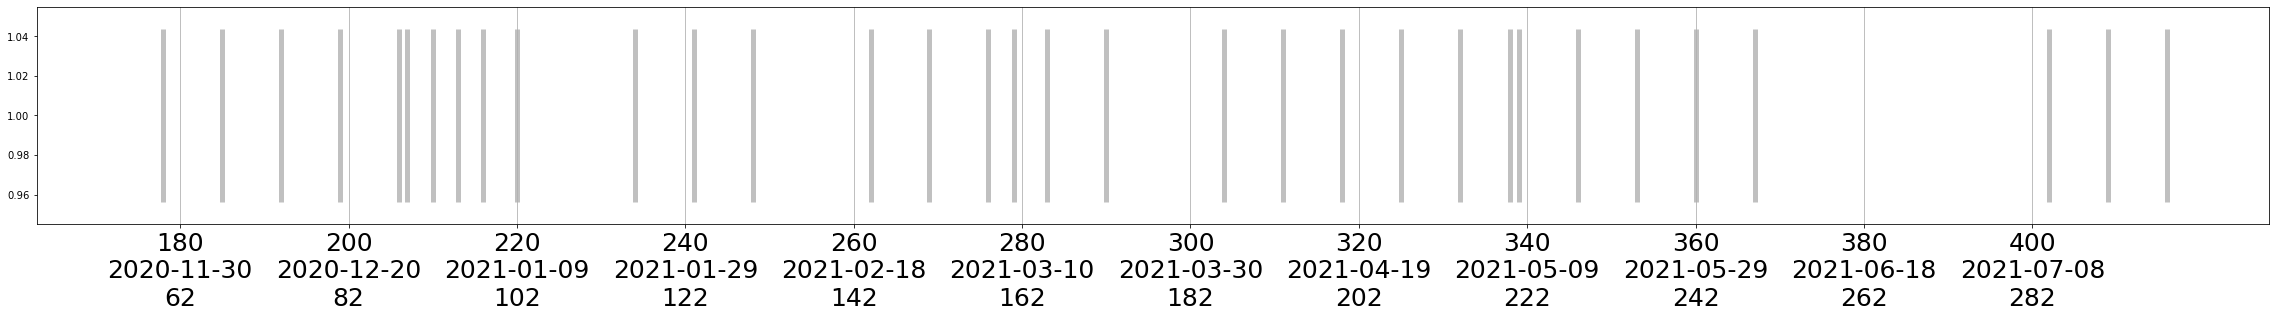

In [49]:
#or single color could be: darkgrey
#finally keep all black, but kept the script that way in case we change mind
dico_c_color = {'LP10':'silver',
                'LP2':'silver',
                'time':'silver',
                'TypicalVaccinationDay':'silver',
                'cold':'silver',
                'NotConsidered':'white',
                'nomvtdata':'white'}
#ensure all days are displayed, even the one we dont tracked, to have a x axis representing the correct amount of time in
#between days considered
li_day = list(range(df_daily['DOA'].min(), df_daily['DOA'].max()+1))
dico_date_c = dict(zip(df_daily['DOA'].tolist(), df_daily['BS_type'].tolist()))
#sort dictionary by keys, as its not ensured to have the keys sorte din the order it was originally
dico_date_c = collections.OrderedDict(sorted(dico_date_c.items()))
#assign a color to each day
dico_date_color = {}
for d in li_day:
    dico_date_color[d] = dico_c_color[dico_date_c.get(d,'nomvtdata')]
#plot
plt.figure(figsize=(40,4))
plt.scatter(dico_date_color.keys(), [1]*len(dico_date_color.keys()), color = list(dico_date_color.values()), 
            s=30000, marker='|', linewidths=5);
plt.xticks([i for i in dico_date_color.keys() if i%20==0], 
           [str(i)+'\n'+str(dt.datetime(2020,11,30)+dt.timedelta(days=(i-180))).split(' ')[0]+'\n'+str(i-118) for i in dico_date_color.keys() if i%20==0],
           rotation=0)
#plt.xticks([i for i in dico_date_color.keys() if i%10==0],rotation=0)
plt.grid(axis="x")
plt.xticks(fontsize=25)
#plt.xlabel('day of age', size=26)
plt.savefig(os.path.join(path_extracted_data,'BS_DaysSelected_B&W_doa.png'), bbox_inches='tight')

In [50]:
#check date and day in the barn (DIB)
#small test:
x = 320
print(dt.datetime(2020,11,30)+dt.timedelta(days=(x-180)))
print(x-118)
display(df_daily[df_daily['DOA'].isin([180,200,220,240,260,280,300,320,340,360,380,400])][['DIB','DOA','level']].sort_values('DOA').drop_duplicates().head(20))

2021-04-19 00:00:00
202


,DIB,DOA,level
5,62,180,2020-11-30
5167,82,200,2020-12-20
11245,102,220,2021-01-09
27821,142,260,2021-02-18
7545,162,280,2021-03-10
6329,182,300,2021-03-30
30115,202,320,2021-04-19
13748,222,340,2021-05-09
11167,242,360,2021-05-29
29722,282,400,2021-07-08


In [51]:
#check date and day in the barn (DIB)
display(df_daily[df_daily['DOA'].isin([df_daily['DOA'].min(),df_daily['DOA'].max()])][['DIB','DOA','level']].sort_values('DOA').drop_duplicates().head(20))

,DIB,DOA,level
0,57,175,2020-11-25
2922,298,416,2021-07-24


In [52]:
print(df_daily['level'].min(), df_daily['level'].max())
print((df_daily['level'].max()-df_daily['level'].min()).days)
print((df_daily['level'].max()-df_daily['level'].min()).days/30)

2020-11-25 00:00:00 2021-07-24 00:00:00
241
8.033333333333333


# Save mvt for behavioural syndrome

In [53]:
dico_penid_penidfood = {'pen3':'FoodPenID1-4', 
                        'pen4':'FoodPenID1-4', 
                        'pen5':'FoodPenID5-8', 
                        'pen8':'FoodPenID5-8', 
                        'pen9':'FoodPenID9-12',
                        'pen10':'FoodPenID9-12', 
                        'pen11':'FoodPenID9-12', 
                        'pen12':'FoodPenID9-12', }
df_daily['FoodPenID'] = df_daily['PenID'].map(lambda x: dico_penid_penidfood[x])

In [54]:
#Z4: day after the VD and CET, like night: night that follow
li_Z4mvt = ['mid_cum_Z4_h_Morning']
for mv in li_Z4mvt:
    #not efficient way, but easy
    df_daily[mv+'_dafter'] = df_daily.apply(lambda x: df_daily[(df_daily['HenID']==x['HenID'])&\
                                                               (df_daily['DIB']==x['DIB']+1)][mv].values, axis=1)
    df_daily[mv+'_dafter'] = df_daily[mv+'_dafter'].map(lambda x: x[0] if len(x)==1 else np.nan)
    display(df_daily[df_daily['BS_type'].isin(['cold','TypicalVaccinationDay'])][[mv+'_dafter',mv]].head(3))
    
#replace the value to avoid having two columns depending on the context etc. would be annoying for the across context too
for mv in li_Z4mvt:
    df_daily[mv] = np.where(df_daily['BS_type'].isin(['cold','TypicalVaccinationDay']), 
                                df_daily[mv+'_dafter'], #when condtion is trux
                                df_daily[mv])
    display(df_daily[df_daily['BS_type'].isin(['cold','TypicalVaccinationDay'])][[mv+'_dafter',mv]].head(3))

,mid_cum_Z4_h_Morning_dafter,mid_cum_Z4_h_Morning
31,3.849722,3.791389
34,3.901389,4.036111
39,4.071667,3.975833


,mid_cum_Z4_h_Morning_dafter,mid_cum_Z4_h_Morning
31,3.849722,3.849722
34,3.901389,3.901389
39,4.071667,4.071667


In [55]:
print(list(df_daily.columns))

['HenID', 'level', 'verification_daily_total_duration', 'verification_daily_total_nbr_hour', 'dur_values', 'perc_duration_3_Zone', 'perc_duration_4_Zone', 'perc_duration_5_Zone', 'perc_duration_2_Zone', 'perc_duration_1_Zone', 'time_wg_open_sec', 'duration_sincedaystarted_beforeWGopened_sec', 'perc_1_Zone_while_WG_open', 'FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone', 'FirstTimestamp_4_Zone', 'FirstTimestamp_5_Zone', 'nbr_h_WGopen', 'FirstTimestamp_1_Zone_sec', 'latency_1_Zone_h', 'Total_number_zone', 'list_of_durations', 'nestboxes_related_behavior', 'mid_cum_Z4_sec', 'Total_number_transition', 'nbr_stays', 'distribution_entropy', 'vertical_travel_distance', 'vertical_travel_distance_dawn', 'vertical_travel_distance_dusk', 'nbr_stays_total', 'nbr_stays_3_Zone', 'nbr_stays_4_Zone', 'nbr_stays_5_Zone', 'nbr_stays_2_Zone', 'nbr_stays_1_Zone', 'PenID', 'CLASS', 'R-Pen', 'InitialStartDate', 'early_death', 'Treatment', 'TagID', 'FocalLegringName', 'night_level', '

In [56]:
df_BS = df_daily[(df_daily['BS_type']!='NotConsidered')][['TrackingSystemID','level','DOA','WOA','DIB','FoodPenID','BS_type','Treatment','CLASS','PenID',
                                                         'temperature_C_avg','HenID','across_context',
                                                         'KBF_interp','weight_interp',
                                                         'WentinWG','mid_cum_Z4_h_Morning','Sleeping_Uppest', 
                                                         'vertical_travel_distance_fulllight_perinsideh',
                                                          'food_sameDurTiming_r50_final']].copy()
print(df_BS.shape)
df_BS = df_BS[~df_BS['mid_cum_Z4_h_Morning'].isnull()]
print(df_BS.shape)
df_BS = df_BS[~df_BS['WentinWG'].isnull()]
print(df_BS.shape)
df_BS = df_BS[~df_BS['Sleeping_Uppest'].isnull()]
print(df_BS.shape)
df_BS = df_BS[~df_BS['vertical_travel_distance_fulllight_perinsideh'].isnull()]
print(df_BS.shape)
df_BS = df_BS[~df_BS['food_sameDurTiming_r50_final'].isnull()]
print(df_BS.shape)
df_BS = df_BS[~df_BS['KBF_interp'].isnull()] 
print(df_BS.shape)
df_BS = df_BS[~df_BS['weight_interp'].isnull()]
print(df_BS.shape)
#only one so we removed it in order to use a gamma without adding a cst
df_BS = df_BS[df_BS['vertical_travel_distance_fulllight_perinsideh']!=0]
print(df_BS.shape)
display(df_BS.groupby(['BS_type'])['WentinWG'].value_counts(normalize=True))
display(df_BS.groupby(['BS_type'])['Sleeping_Uppest'].value_counts(normalize=True))
df_BS.to_csv(os.path.join(path_extracted_data,'df_BS.csv'), index=False, sep=',')
print('show columns with max amount of nan')
display(df_BS.isna().sum(axis=0).sort_values().tail(15))
df_BS.head(5)

(5076, 20)
(5062, 20)
(5062, 20)
(5062, 20)
(5062, 20)
(5062, 20)
(5047, 20)
(5047, 20)
(5047, 20)


BS_type                WentinWG
LP10                   1           0.691441
                       0           0.308559
LP2                    1           0.617521
                       0           0.382479
TypicalVaccinationDay  1           0.611111
                       0           0.388889
cold                   1           0.600849
                       0           0.399151
time                   1           0.646746
                       0           0.353254
Name: WentinWG, dtype: float64

BS_type                Sleeping_Uppest
LP10                   1                  0.585586
                       0                  0.414414
LP2                    1                  0.685897
                       0                  0.314103
TypicalVaccinationDay  1                  0.707265
                       0                  0.292735
cold                   1                  0.696391
                       0                  0.303609
time                   1                  0.702441
                       0                  0.297559
Name: Sleeping_Uppest, dtype: float64

show columns with max amount of nan


KBF_interp                                         0
across_context                                     0
HenID                                              0
vertical_travel_distance_fulllight_perinsideh      0
PenID                                              0
Treatment                                          0
BS_type                                            0
FoodPenID                                          0
DIB                                                0
WOA                                                0
DOA                                                0
level                                              0
CLASS                                              0
food_sameDurTiming_r50_final                       0
temperature_C_avg                                156
dtype: int64

,TrackingSystemID,level,DOA,WOA,DIB,FoodPenID,BS_type,Treatment,CLASS,PenID,temperature_C_avg,HenID,across_context,KBF_interp,weight_interp,WentinWG,mid_cum_Z4_h_Morning,Sleeping_Uppest,vertical_travel_distance_fulllight_perinsideh,food_sameDurTiming_r50_final
3,TrackingSystem 10-12,2020-11-28,178,26,60,FoodPenID9-12,LP2,TRAN,REXP,pen10,0.666667,hen_131,1,0.0,1745.083333,1,3.836111,1,5.972540,0.50
10,TrackingSystem 10-12,2020-12-05,185,27,67,FoodPenID9-12,LP2,TRAN,REXP,pen10,1.666667,hen_131,0,0.0,1763.400000,1,4.181111,1,5.160926,0.56
17,TrackingSystem 10-12,2020-12-12,192,28,74,FoodPenID9-12,LP2,TRAN,REXP,pen10,3.666667,hen_131,0,0.0,1781.716667,1,4.240000,1,6.104517,0.16
24,TrackingSystem 10-12,2020-12-19,199,29,81,FoodPenID9-12,time,TRAN,REXP,pen10,2.833333,hen_131,0,0.0,1800.033333,1,5.444444,1,3.727923,0.08
30,TrackingSystem 10-12,2020-12-26,206,30,88,FoodPenID9-12,time,TRAN,REXP,pen10,1.500000,hen_131,0,0.0,1818.350000,1,4.093611,1,6.981209,0.57


# Important numbers

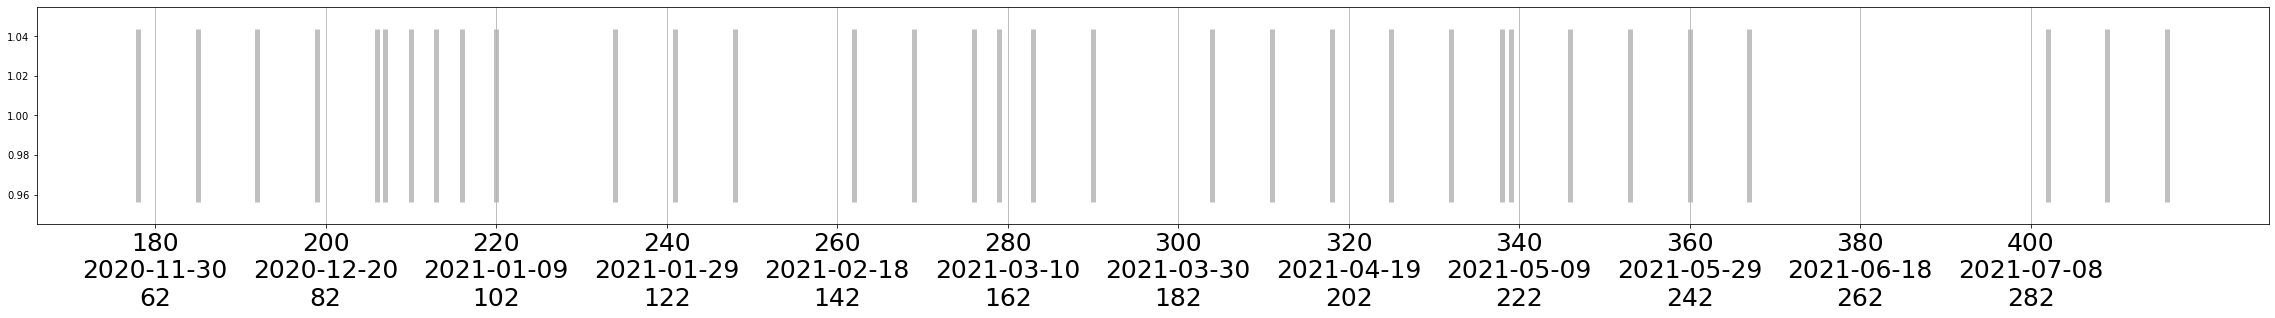

In [76]:
#or single color could be: darkgrey
dico_c_color = {'LP10':'silver',
                'LP2':'silver',
                'time':'silver',
                'TypicalVaccinationDay':'silver',
                'cold':'silver',
                'NotConsidered':'white',
                'nomvtdata':'white'}
#ensure all days are displayed, even the one we dont tracked, to have a x axis representing the correct amount of time in
#between days considered
li_day = list(range(df_BS['DOA'].min(), df_BS['DOA'].max()+1))
dico_date_c = dict(zip(df_BS['DOA'].tolist(), df_BS['BS_type'].tolist()))
#sort dictionary by keys, as its not ensured to have the keys sorte din the order it was originally
dico_date_c = collections.OrderedDict(sorted(dico_date_c.items()))
#assign a color to each day
dico_date_color = {}
for d in li_day:
    dico_date_color[d] = dico_c_color[dico_date_c.get(d,'nomvtdata')]
#plot
plt.figure(figsize=(40,4))
plt.scatter(dico_date_color.keys(), [1]*len(dico_date_color.keys()), color = list(dico_date_color.values()), 
            s=30000, marker='|', linewidths=5);
plt.xticks([i for i in dico_date_color.keys() if i%20==0], 
           [str(i)+'\n'+str(dt.datetime(2020,11,30)+dt.timedelta(days=(i-180))).split(' ')[0]+'\n'+str(i-118) for i in dico_date_color.keys() if i%20==0],
           rotation=0)
#plt.xticks([i for i in dico_date_color.keys() if i%10==0],rotation=0)
plt.grid(axis="x")
plt.xticks(fontsize=25)
#plt.xlabel('day of age', size=26)
plt.savefig(os.path.join(path_extracted_data,'BS_DaysSelected_dfBS__B&W_doa.png'), bbox_inches='tight')

In [58]:
print('context: number of days in total, in between obs & between min and max')
#level has become string now wth the agg to df_BS. lets use DIB
df_info = df_BS.groupby('BS_type')[['DIB','level']].agg(lambda x: sorted([i for i in set(x)])).reset_index()
df_info['nbr_days'] = df_info['DIB'].map(lambda x: len(x))
df_info['#days between max and min days considered'] = df_info['DIB'].map(lambda x: max(x)-min(x))
df_info['#days in between 2 consecutive obs'] = df_info['DIB'].map(lambda x: [sorted(x)[i]-sorted(x)[i-1] for i in range(1,len(x))])
df_info['avg #days in between 2 consecutive obs'] = df_info['#days in between 2 consecutive obs'].map(lambda x: np.mean(x))
df_info

context: number of days in total, in between obs & between min and max


,BS_type,DIB,level,nbr_days,#days between max and min days considered,#days in between 2 consecutive obs,avg #days in between 2 consecutive obs
0,LP10,"[284, 291, 298]","[2021-07-10 00:00:00, 2021-07-17 00:00:00, 202...",3,14,"[7, 7]",7.0
1,LP2,"[60, 67, 74]","[2020-11-28 00:00:00, 2020-12-05 00:00:00, 202...",3,14,"[7, 7]",7.0
2,TypicalVaccinationDay,"[92, 161, 220]","[2020-12-30 00:00:00, 2021-03-09 00:00:00, 202...",3,128,"[69, 59]",64.0
3,cold,"[89, 98, 102]","[2020-12-27 00:00:00, 2021-01-05 00:00:00, 202...",3,13,"[9, 4]",6.5
4,time,"[81, 88, 95, 116, 123, 130, 144, 151, 158, 165...","[2020-12-19 00:00:00, 2020-12-26 00:00:00, 202...",21,168,"[7, 7, 21, 7, 7, 14, 7, 7, 7, 7, 14, 7, 7, 7, ...",8.4


In [59]:
print('acros context: number of days in total, in between obs & between min and max')
#level has become string now wth the agg to df_BS. lets use DIB
df_info = df_BS.groupby('across_context')[['DIB','level']].agg(lambda x: sorted([i for i in set(x)])).reset_index()
df_info['nbr_days'] = df_info['DIB'].map(lambda x: len(x))
df_info['#days between max and min days considered'] = df_info['DIB'].map(lambda x: max(x)-min(x))
df_info['#days in between 2 consecutive obs'] = df_info['DIB'].map(lambda x: [sorted(x)[i]-sorted(x)[i-1] for i in range(1,len(x))])
df_info['avg #days in between 2 consecutive obs'] = df_info['#days in between 2 consecutive obs'].map(lambda x: np.mean(x))
df_info

acros context: number of days in total, in between obs & between min and max


,across_context,DIB,level,nbr_days,#days between max and min days considered,#days in between 2 consecutive obs,avg #days in between 2 consecutive obs
0,0,"[67, 74, 81, 88, 92, 95, 98, 102, 116, 123, 13...","[2020-12-05 00:00:00, 2020-12-12 00:00:00, 202...",29,224,"[7, 7, 7, 4, 3, 3, 4, 14, 7, 7, 14, 7, 7, 7, 7...",8.000000
1,1,"[60, 89, 161, 298]","[2020-11-28 00:00:00, 2020-12-27 00:00:00, 202...",4,238,"[29, 72, 137]",79.333333


In [60]:
print('number of hens with x days within each context')
df_ = df_BS[df_BS['BS_type']!='time'].groupby(['BS_type','HenID'])['level'].count().reset_index()
df_.rename(columns={'level':'#available days'}, inplace=True)
#display(df_.head(3))
display(df_.groupby(['BS_type','#available days'])['HenID'].count().reset_index())

number of hens with x days within each context


,BS_type,#available days,HenID
0,LP10,1,4
1,LP10,2,7
2,LP10,3,142
3,LP2,1,1
4,LP2,2,1
5,LP2,3,155
6,TypicalVaccinationDay,1,36
7,TypicalVaccinationDay,2,39
8,TypicalVaccinationDay,3,118
9,cold,1,2


In [61]:
print('number of hens with x days over time situation')
df_ = df_BS[df_BS['BS_type']=='time'].groupby(['HenID'])['level'].count().reset_index()
df_.rename(columns={'level':'#available days'}, inplace=True)
#display(df_.head(3))
#df_BS[df_BS['BS_type']=='time'].groupby(['level'])['HenID'].count().reset_index() #no days with small less than 112 ind.
display(df_.groupby(['#available days'])['HenID'].count().reset_index())
#95% of over time: is 20 and 21: 48+59=107

number of hens with x days over time situation


,#available days,HenID
0,1,1
1,4,4
2,5,13
3,6,1
4,7,3
5,8,15
6,12,5
7,13,13
8,14,3
9,15,2


In [62]:
print('number of hens with x days across context situation')
df_ = df_BS[df_BS['across_context']==1].groupby(['HenID'])['level'].count().reset_index()
df_.rename(columns={'level':'#available days'}, inplace=True)
#display(df_.head(3))
display(df_.groupby(['#available days'])['HenID'].count().reset_index())

number of hens with x days across context situation


,#available days,HenID
0,1,15
1,2,36
2,3,30
3,4,109


In [63]:
#mean number of days between any two observations for context
df_comb = df_BS.groupby(['BS_type'])['DIB'].agg(lambda x: list(set(x))).reset_index()
df_comb['li_comb'] = df_comb['DIB'].map(lambda x: list(combinations(x, 2)))
df_comb['li_meaninterval'] = df_comb['li_comb'].map(lambda x: [abs(x1-x0) for x0,x1 in x])
df_comb['mean_nbr_days_beteenany_2obs'] = df_comb['li_meaninterval'].map(lambda x: np.mean(x))
df_comb

,BS_type,DIB,li_comb,li_meaninterval,mean_nbr_days_beteenany_2obs
0,LP10,"[298, 291, 284]","[(298, 291), (298, 284), (291, 284)]","[7, 14, 7]",9.333333
1,LP2,"[74, 67, 60]","[(74, 67), (74, 60), (67, 60)]","[7, 14, 7]",9.333333
2,TypicalVaccinationDay,"[161, 220, 92]","[(161, 220), (161, 92), (220, 92)]","[59, 69, 128]",85.333333
3,cold,"[89, 98, 102]","[(89, 98), (89, 102), (98, 102)]","[9, 13, 4]",8.666667
4,time,"[130, 144, 151, 158, 165, 172, 186, 193, 200, ...","[(130, 144), (130, 151), (130, 158), (130, 165...","[14, 21, 28, 35, 42, 56, 63, 70, 77, 49, 84, 4...",61.600000


In [64]:
#mean number of days between any two observations for across context
df_comb = df_BS.groupby(['across_context'])['DIB'].agg(lambda x: list(set(x))).reset_index()
df_comb['li_comb'] = df_comb['DIB'].map(lambda x: list(combinations(x, 2)))
df_comb['li_meaninterval'] = df_comb['li_comb'].map(lambda x: [abs(x1-x0) for x0,x1 in x])
df_comb['mean_nbr_days_beteenany_2obs'] = df_comb['li_meaninterval'].map(lambda x: np.mean(x))
df_comb

,across_context,DIB,li_comb,li_meaninterval,mean_nbr_days_beteenany_2obs
0,0,"[130, 144, 151, 284, 158, 291, 165, 172, 186, ...","[(130, 144), (130, 151), (130, 284), (130, 158...","[14, 21, 154, 28, 161, 35, 42, 56, 63, 63, 70,...",76.512315
1,1,"[89, 298, 161, 60]","[(89, 298), (89, 161), (89, 60), (298, 161), (...","[209, 72, 29, 137, 238, 101]",131.000000


In [65]:
mi = min(df_BS['DOA'].tolist())
ma = max(df_BS['DOA'].tolist())
print('We are involving a period of %d days (%.2f months) of tracking during the days from the DOA %d until DOA %d'%(ma-mi+1, (ma-mi+1)/30.4,mi, ma))

mi = min(df_BS['WOA'].tolist())
ma = max(df_BS['WOA'].tolist())
print('We are involving a period of %d weeks of tracking during the days from the WOA %d until WOA %d'%(ma-mi+1, mi, ma))

df_info = df_BS.groupby(['HenID'])['DOA','level','PenID'].agg(lambda x: list(x)).reset_index()
df_info['nbrDaysTracked'] = df_info['DOA'].map(lambda x: len(set(x)))
df_info = df_info.sort_values(['nbrDaysTracked'])
display(df_info.head(3))
display(df_info.tail(3))
#pen 5 had issues with batteries of markers!
display(df_info['nbrDaysTracked'].mean())

print('Hens had in average %d days tracked with a minimum of %d days tracked and a maximum of %d days tracked.'%(round(df_info['nbrDaysTracked'].mean(),0),
                                                                                df_info['nbrDaysTracked'].min(),  
                                                                                df_info['nbrDaysTracked'].max()))
print('In other words, %d hens were used in subsequent analysis with a total of %d observations.'%(len(df_BS['HenID'].unique()),
                                                                                                   df_BS.shape[0]))

We are involving a period of 239 days (7.86 months) of tracking during the days from the DOA 178 until DOA 416
We are involving a period of 35 weeks of tracking during the days from the WOA 26 until WOA 60


C:\Users\camil\AppData\Local\Temp/ipykernel_14904/1178520601.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_info = df_BS.groupby(['HenID'])['DOA','level','PenID'].agg(lambda x: list(x)).reset_index()


,HenID,DOA,level,PenID,nbrDaysTracked
106,hen_213,[248],[2021-02-06 00:00:00],[pen8],1
112,hen_219,"[318, 325, 332, 338, 339, 346, 353, 360]","[2021-04-17 00:00:00, 2021-04-24 00:00:00, 202...","[pen10, pen10, pen10, pen10, pen10, pen10, pen...",8
128,hen_233,"[318, 325, 332, 338, 339, 346, 353, 360, 367, ...","[2021-04-17 00:00:00, 2021-04-24 00:00:00, 202...","[pen9, pen9, pen9, pen9, pen9, pen9, pen9, pen...",10


,HenID,DOA,level,PenID,nbrDaysTracked
50,hen_156,"[178, 185, 192, 199, 206, 207, 210, 213, 216, ...","[2020-11-28 00:00:00, 2020-12-05 00:00:00, 202...","[pen4, pen4, pen4, pen4, pen4, pen4, pen4, pen...",33
23,hen_128,"[178, 185, 192, 199, 206, 207, 210, 213, 216, ...","[2020-11-28 00:00:00, 2020-12-05 00:00:00, 202...","[pen4, pen4, pen4, pen4, pen4, pen4, pen4, pen...",33
130,hen_25,"[178, 185, 192, 199, 206, 207, 210, 213, 216, ...","[2020-11-28 00:00:00, 2020-12-05 00:00:00, 202...","[pen3, pen3, pen3, pen3, pen3, pen3, pen3, pen...",33


26.015463917525775

Hens had in average 26 days tracked with a minimum of 1 days tracked and a maximum of 33 days tracked.
In other words, 194 hens were used in subsequent analysis with a total of 5047 observations.


# Visual observed behavior

In [66]:
df_BS = pd.read_csv(os.path.join(path_extracted_data,'df_BS.csv'), sep=',')
display(df_BS.head(3))
li_mvt_cont = ['vertical_travel_distance_fulllight_perinsideh','food_sameDurTiming_r50_final','mid_cum_Z4_h_Morning']
li_mvt_bin = ['WentinWG','Sleeping_Uppest']

,TrackingSystemID,level,DOA,WOA,DIB,FoodPenID,BS_type,Treatment,CLASS,PenID,temperature_C_avg,HenID,across_context,KBF_interp,weight_interp,WentinWG,mid_cum_Z4_h_Morning,Sleeping_Uppest,vertical_travel_distance_fulllight_perinsideh,food_sameDurTiming_r50_final
0,TrackingSystem 10-12,2020-11-28,178,26,60,FoodPenID9-12,LP2,TRAN,REXP,pen10,0.666667,hen_131,1,0.0,1745.083333,1,3.836111,1,5.972540,0.50
1,TrackingSystem 10-12,2020-12-05,185,27,67,FoodPenID9-12,LP2,TRAN,REXP,pen10,1.666667,hen_131,0,0.0,1763.400000,1,4.181111,1,5.160926,0.56
2,TrackingSystem 10-12,2020-12-12,192,28,74,FoodPenID9-12,LP2,TRAN,REXP,pen10,3.666667,hen_131,0,0.0,1781.716667,1,4.240000,1,6.104517,0.16


In [67]:
#first some stat of the behaviours between early vs late life stage
df_ = df_BS[df_BS['BS_type'].isin(['LP2', 'LP10'])].groupby(['BS_type','level'])[li_mvt_cont+li_mvt_bin+['DOA','WOA','temperature_C_avg','KBF_interp','weight_interp']].mean().reset_index()
display(df_)
df_ = df_.groupby(['BS_type']).mean().reset_index()
df_

,BS_type,level,vertical_travel_distance_fulllight_perinsideh,food_sameDurTiming_r50_final,mid_cum_Z4_h_Morning,WentinWG,Sleeping_Uppest,DOA,WOA,temperature_C_avg,KBF_interp,weight_interp
0,LP10,2021-07-10,3.682216,0.257285,5.238245,0.841060,0.543046,402.0,58.0,22.833333,35.580107,1886.454852
1,LP10,2021-07-17,3.570479,0.278311,5.288530,0.770270,0.628378,409.0,59.0,20.333333,35.956341,1887.001767
2,LP10,2021-07-24,2.997701,0.217172,5.466169,0.455172,0.586207,416.0,60.0,24.833333,36.555703,1884.104516
3,LP2,2020-11-28,3.592076,0.197134,4.435656,0.528662,0.707006,178.0,26.0,0.666667,7.836215,1691.815848
4,LP2,2020-12-05,4.083172,0.181731,4.414790,0.673077,0.679487,185.0,27.0,1.666667,9.357143,1708.555806
5,LP2,2020-12-12,3.974776,0.242903,4.246283,0.651613,0.670968,192.0,28.0,3.666667,10.899232,1724.280366


C:\Users\camil\AppData\Local\Temp/ipykernel_14904/1875906312.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_ = df_.groupby(['BS_type']).mean().reset_index()


,BS_type,vertical_travel_distance_fulllight_perinsideh,food_sameDurTiming_r50_final,mid_cum_Z4_h_Morning,WentinWG,Sleeping_Uppest,DOA,WOA,temperature_C_avg,KBF_interp,weight_interp
0,LP10,3.416798,0.250923,5.330981,0.688834,0.585877,409.0,59.0,22.666667,36.030717,1885.853712
1,LP2,3.883341,0.207256,4.365576,0.617784,0.685820,185.0,27.0,2.000000,9.364197,1708.217340


### boxplot within each context

['LP2' 'time' 'cold' 'TypicalVaccinationDay' 'LP10']


,BS_type,variable,value
0,LP2,vertical_travel_distance_fulllight_perinsideh,5.972540
1,LP2,vertical_travel_distance_fulllight_perinsideh,5.160926
2,LP2,vertical_travel_distance_fulllight_perinsideh,6.104517


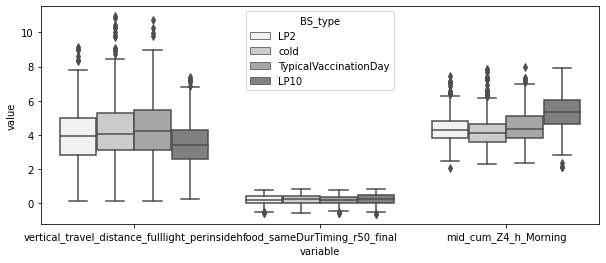

In [68]:
plt.figure(figsize=(10,4))
print(df_BS['BS_type'].unique())
df_plt = df_BS[df_BS['BS_type'].isin(['TypicalVaccinationDay','cold','LP10','LP2'])].copy()
#df_plt[li_mvt_cont]=(df_plt[li_mvt_cont]-df_plt[li_mvt_cont].min())/(df_plt[li_mvt_cont].max()-df_plt[li_mvt_cont].min())
df_plt = pd.melt(df_plt, id_vars=['BS_type'], value_vars=li_mvt_cont, value_name = 'value')
display(df_plt.head(3))
sns.boxplot(x="variable", y='value', data=df_plt, hue = 'BS_type', color='grey'); #fliersize=0.1, 
plt.show();

['LP2' 'time' 'cold' 'TypicalVaccinationDay' 'LP10']


,BS_type,variable,value
0,LP2,vertical_travel_distance_fulllight_perinsideh,0.540075
1,LP2,vertical_travel_distance_fulllight_perinsideh,0.464983
2,LP2,vertical_travel_distance_fulllight_perinsideh,0.552286


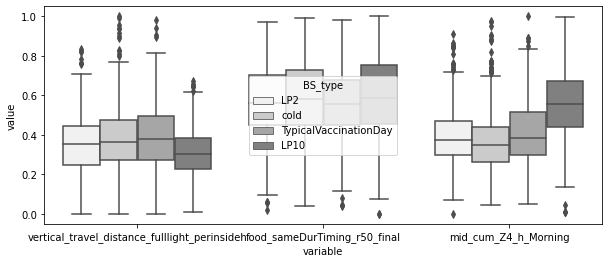

In [69]:
#normalised to have same y-axis between behaviors
plt.figure(figsize=(10,4))
print(df_BS['BS_type'].unique())
df_plt = df_BS[df_BS['BS_type'].isin(['TypicalVaccinationDay','cold','LP10','LP2'])].copy()
df_plt[li_mvt_cont]=(df_plt[li_mvt_cont]-df_plt[li_mvt_cont].min())/(df_plt[li_mvt_cont].max()-df_plt[li_mvt_cont].min())
df_plt = pd.melt(df_plt, id_vars=['BS_type'], value_vars=li_mvt_cont, value_name = 'value')
display(df_plt.head(3))
sns.boxplot(x="variable", y='value', data=df_plt, hue = 'BS_type', color='grey'); #fliersize=0.1, 
plt.show();

['LP2' 'time' 'cold' 'TypicalVaccinationDay' 'LP10']


,BS_type,variable,value
0,LP2,vertical_travel_distance_fulllight_perinsideh,0.452972
1,LP2,vertical_travel_distance_fulllight_perinsideh,0.389990
2,LP2,vertical_travel_distance_fulllight_perinsideh,0.463213


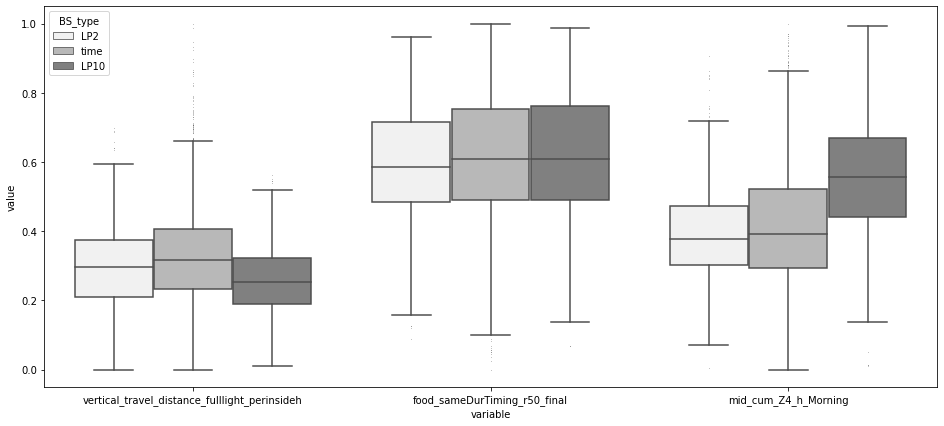

In [70]:
plt.figure(figsize=(16,7))
print(df_BS['BS_type'].unique())
df_plt = df_BS[df_BS['BS_type'].isin(['time','LP10','LP2'])].copy()
df_plt[li_mvt_cont]=(df_plt[li_mvt_cont]-df_plt[li_mvt_cont].min())/(df_plt[li_mvt_cont].max()-df_plt[li_mvt_cont].min())
df_plt = pd.melt(df_plt, id_vars=['BS_type'], value_vars=li_mvt_cont, value_name = 'value')
display(df_plt.head(3))
sns.boxplot(x="variable", y='value', data=df_plt, hue = 'BS_type', fliersize=0.1, color='grey');
plt.show();

### observed behavior over time

['LP2' 'time' 'cold' 'TypicalVaccinationDay' 'LP10']


,DIB,variable,value
0,60,vertical_travel_distance_fulllight_perinsideh,0.452972
1,67,vertical_travel_distance_fulllight_perinsideh,0.389990
2,74,vertical_travel_distance_fulllight_perinsideh,0.463213


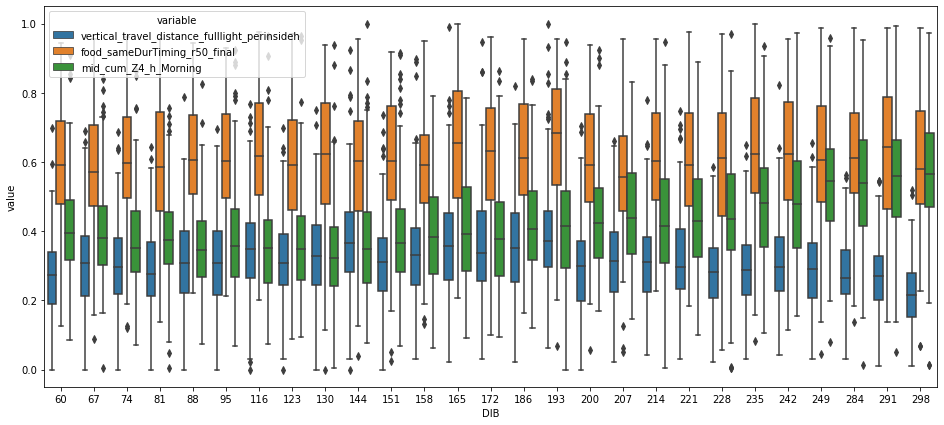

In [71]:
plt.figure(figsize=(16,7))
print(df_BS['BS_type'].unique())
df_plt = df_BS[df_BS['BS_type'].isin(['time','LP10','LP2'])].copy()
df_plt[li_mvt_cont]=(df_plt[li_mvt_cont]-df_plt[li_mvt_cont].min())/(df_plt[li_mvt_cont].max()-df_plt[li_mvt_cont].min())
df_plt = pd.melt(df_plt, id_vars=['DIB'], value_vars=li_mvt_cont, value_name = 'value')
display(df_plt.head(3))
sns.boxplot(x="DIB", y='value', data=df_plt, hue = 'variable');
plt.show();

['LP2' 'time' 'cold' 'TypicalVaccinationDay' 'LP10']


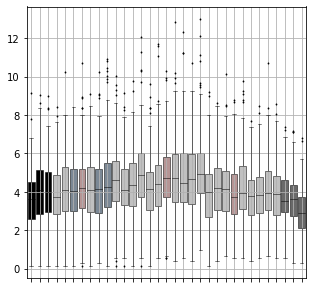

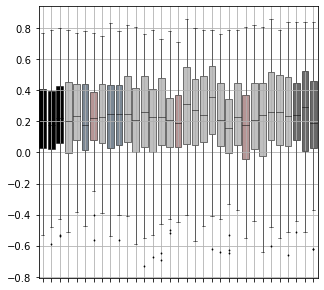

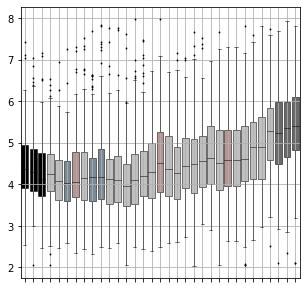

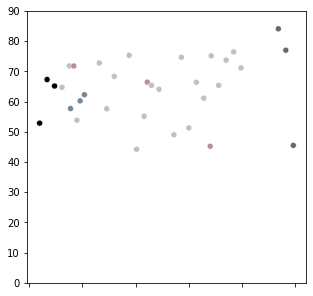

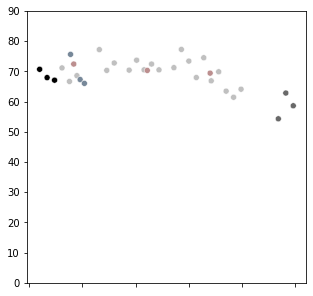

In [74]:
### continuous values 
dico_mvt_name = {'vertical_travel_distance_fulllight_perinsideh':'vertical travelled distance',
                 'food_sameDurTiming_r50_final': 'food reactivity index',
                 'mid_cum_Z4_h_Morning':'mid-timing nestbox usage',
                 'WentinWG':'has been outside',
                 'Sleeping_Uppest':'has slept on upper tier'}

pal_ = {'LP2':'black', 'time':'silver', 'cold':'lightslategray', 'TypicalVaccinationDay':'rosybrown', 'LP10':'dimgrey'}
print(df_BS['BS_type'].unique())
#df_plt = df_BS[df_BS['BS_type'].isin(['time','LP10','LP2'])].copy()
df_plt = df_BS.copy()
for m in li_mvt_cont:
    plt.figure(figsize=(5,5))
    ax = sns.boxplot(x="DIB", y=m, data=df_plt, fliersize=1, linewidth=0.5, hue='BS_type', palette=pal_, dodge=False);
    #sns.boxplot(x="DIB", y=m, data=df_plt, fliersize=2, linewidth=1);
    #sns.boxplot(x="DIB", y=m, data=df_plt[df_plt['BS_type']=='cold'], fliersize=2, linewidth=1, color=pal_['cold']);
    #ax = sns.boxplot(x="DIB", y=m, data=df_plt[df_plt['BS_type']=='LP2'], fliersize=2, linewidth=1, color=pal_['LP2'], ax=ax);
    #ax = sns.boxplot(x="DIB", y=m, data=df_plt[df_plt['BS_type']=='LP10'], fliersize=2, linewidth=1, color=pal_['LP10'], ax=ax);
    ax.legend([],[], frameon=False)
    plt.grid()
    #plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    #ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
    labels = [item.get_text() for item in ax.get_xticklabels()]
    #as we re missing some dates, we cant take all odd number for instance, we need to take one label over two
    ax.set_xticklabels([])#cannot lot xlabel as missing days and we dont want to add them neither, so showing the xlabel is missinformative [labels[i] if int(i)%5==0 else '' for i in range(0,len(labels))])
    #plt.xlabel('time (number of days in the laying barn)')
    #plt.ylabel(dico_mvt_name[m])
    plt.xlabel('')
    plt.ylabel('')
    plt.savefig(os.path.join(path_extracted_data ,'BS_'+m+'_overtime.png'), bbox_inches='tight')
    plt.show();
    
for m in li_mvt_bin:
    #df_plt = df_BS[df_BS['BS_type'].isin(['time','LP10','LP2'])].copy()
    df_plt = df_BS.copy()
    df_plt = df_plt.groupby(['DIB','BS_type'])[m].mean().reset_index()
    df_plt[m] = df_plt[m].map(lambda x: 100*x) #into percentage
    plt.figure(figsize=(5,5))
    #print(df_plt.shape)
    #display(df_plt.head(3))
    #ax = sns.scatterplot(x="DIB", y=m, data=df_plt, hue='BS_type', legend=False, palette=pal_);
    ax = sns.scatterplot(x="DIB", y=m, data=df_plt, hue='BS_type', legend=False, palette=pal_);
    ax.set_xticklabels([])
    #plt.xlabel('time (number of days in the laying barn)')
    #plt.ylabel(dico_mvt_name[m])
    plt.ylim(0,90)
    plt.xlabel('')
    plt.ylabel('')
    plt.savefig(os.path.join(path_extracted_data ,'BS_'+m+'_overtime.png'), bbox_inches='tight')
    plt.show();

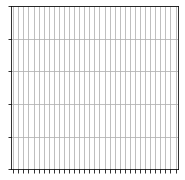

In [73]:
df_plt = df_BS.copy()
df_plt = df_plt.groupby(['DIB','BS_type'])[m].mean().reset_index()
df_plt[m] = df_plt[m].map(lambda x: 100*x) #into percentage
plt.figure(figsize=(3,3))
#print(df_plt.shape)
#display(df_plt.head(3))
pal_ = {'LP2':'black', 'time':'silver', 'cold':'lightslategray', 'TypicalVaccinationDay':'rosybrown', 'LP10':'dimgrey'}
df_plt['m_nan'] = np.nan
ax = sns.pointplot(x="DIB", y='m_nan', data=df_plt) #does not work
ax.legend([],[], frameon=False)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.grid()
plt.ylim(40,90)
plt.xlabel('')
plt.ylabel('')
plt.savefig(os.path.join(path_extracted_data ,'BS_grid_overtime.png'), bbox_inches='tight', transparent=True)
plt.show();

### observed behaviour / hen

#### continuous mvt var

In [59]:
#initialise hens, list if mvt
#same color and different context (OR: coul dhave kept order and use no color, but we wouldn't illustratethe repeabtaitliy 
#within context)
#chose palette: https://seaborn.pydata.org/tutorial/color_palettes.html
df_ = df_BS[df_BS['across_context']==1].groupby(['HenID'])['level'].count().reset_index()
li_hen_plot = df_[df_['level']==4]['HenID'].tolist()
print('We will visualise HERE ONLY the %d hens that are in all across_context observation (and thus also that are in all context at least one time)'%len(li_hen_plot))
#&(df_BS['PenID']=='pen10')
df_BS_plt = df_BS[(df_BS['HenID'].isin(li_hen_plot))][['level','DOA','DIB','BS_type','Treatment','PenID','HenID',
                                                       'across_context']+li_mvt_cont+li_mvt_bin].copy()

We will visualise HERE ONLY the 109 hens that are in all across_context observation (and thus also that are in all context at least one time)


In [60]:
#dataframe to be able to sort hens by mean behavior over the time context only
df_plt = df_BS_plt[df_BS_plt['BS_type']=='time'].groupby(['HenID'])[li_mvt_cont+li_mvt_bin].median().reset_index()
print(df_plt.shape)
df_plt.head(3)

(109, 6)


,HenID,vertical_travel_distance_fulllight_perinsideh,food_sameDurTiming_r50_final,mid_cum_Z4_h_Morning,WentinWG,Sleeping_Uppest
0,hen_10,3.043968,0.08,3.988889,0.0,0.0
1,hen_101,4.940629,0.42,4.592778,1.0,0.0
2,hen_102,2.857937,0.17,3.966111,1.0,1.0


In [61]:
#select 5 random hens and associate them to a nice color
random.seed(1)
li_all_hen = df_plt['HenID'].tolist()
li_hen_visual = random.choices(li_all_hen, k=5)
print(li_hen_visual)
pal_ = {henID:'grey' for henID in li_all_hen}
li_nicecolor_brighter = ['mediumblue','deeppink','goldenrod','green','cyan','yellow']
for i,henID in enumerate(li_hen_visual):
    pal_[henID] = li_nicecolor_brighter[i]

['hen_128', 'hen_69', 'hen_59', 'hen_150', 'hen_189']


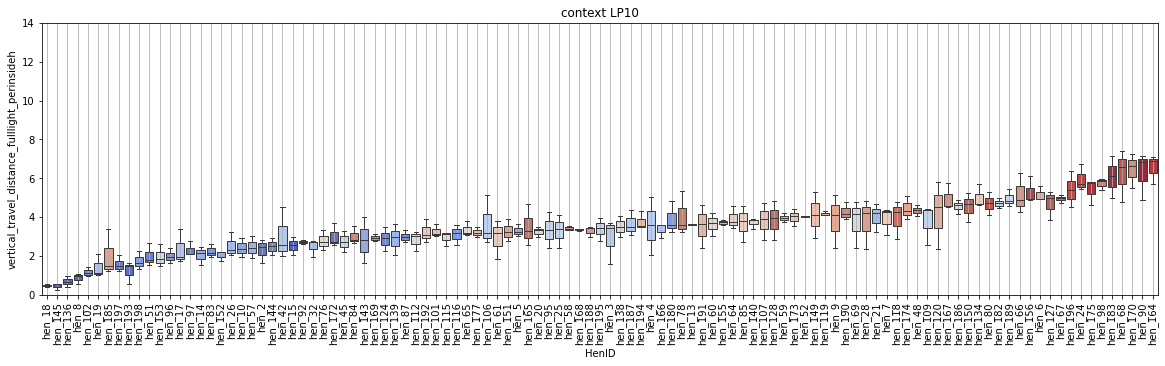

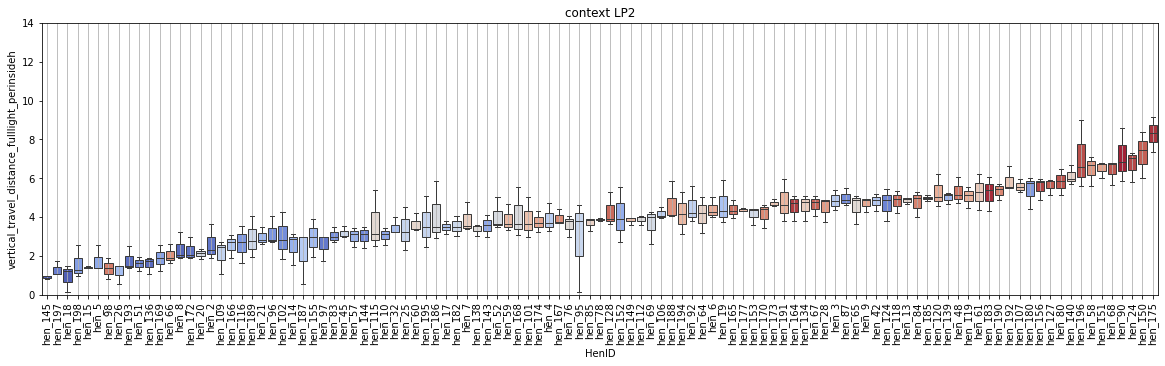

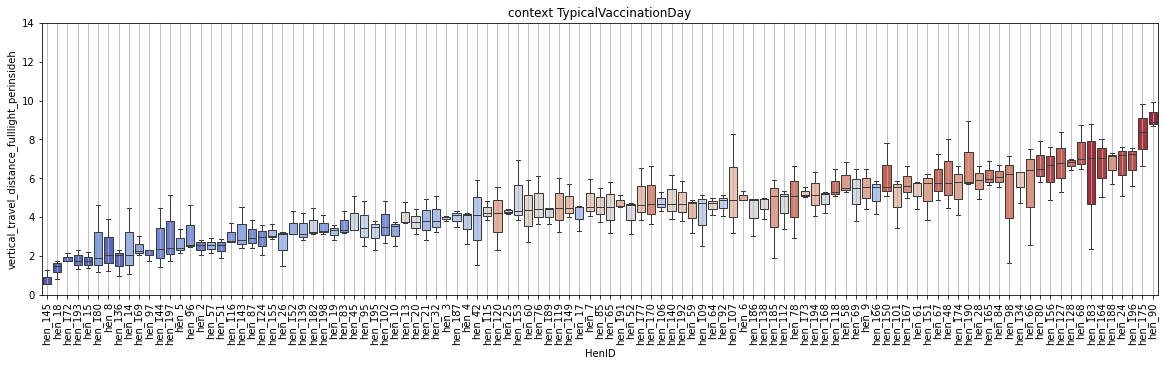

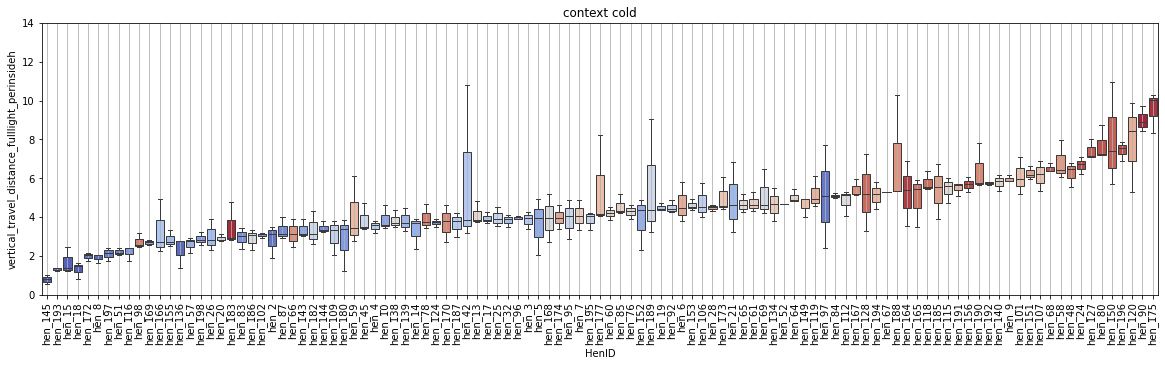

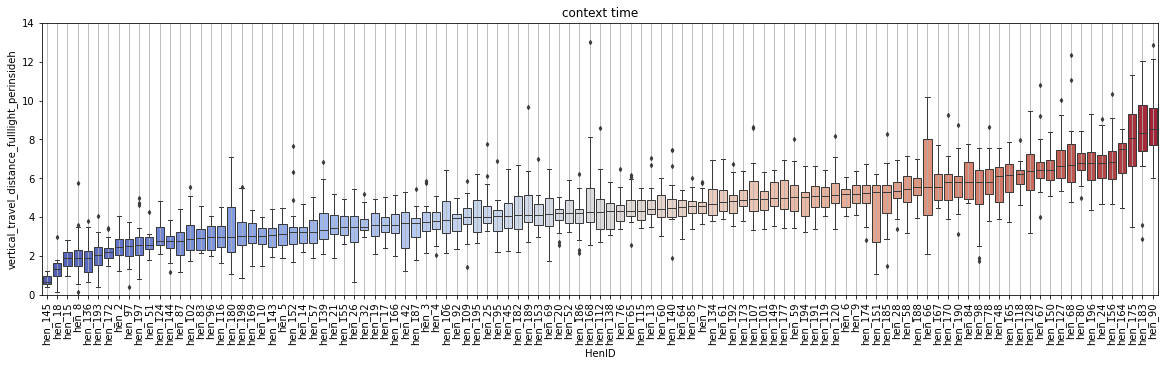

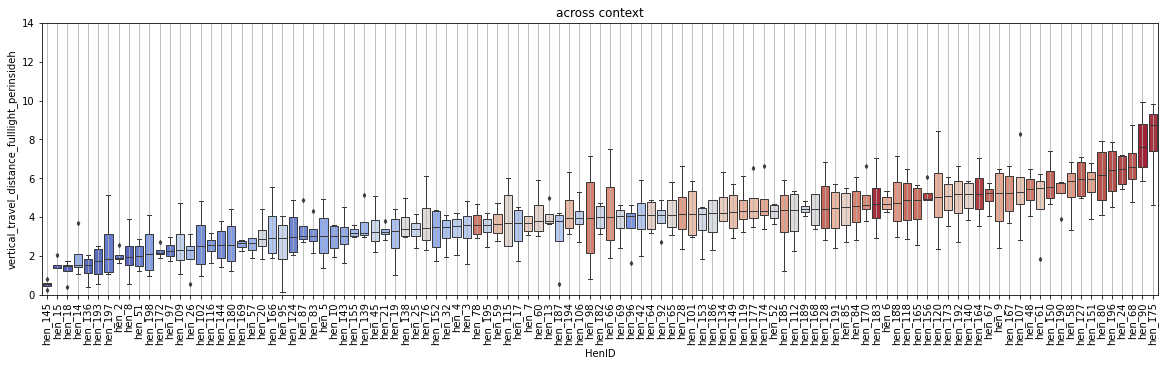

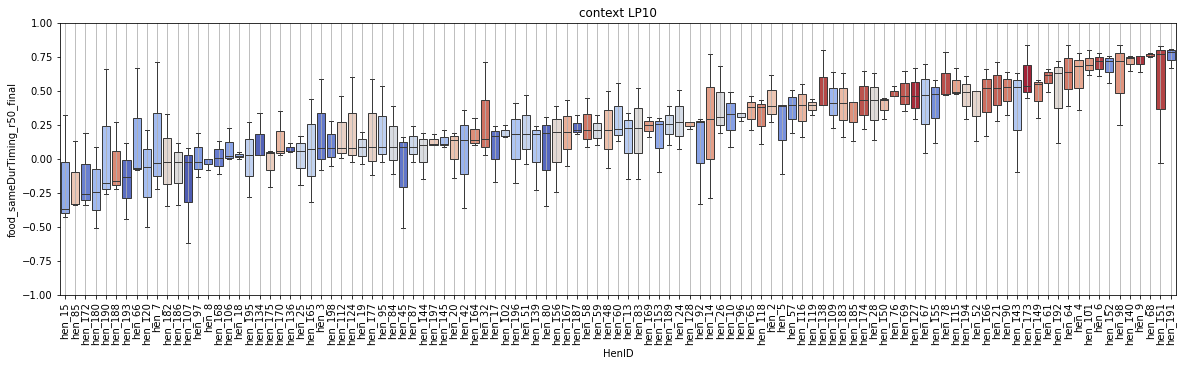

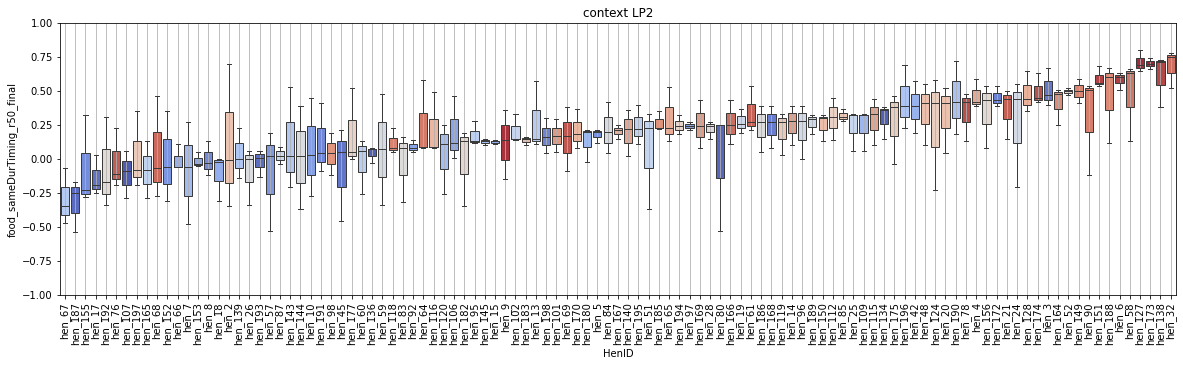

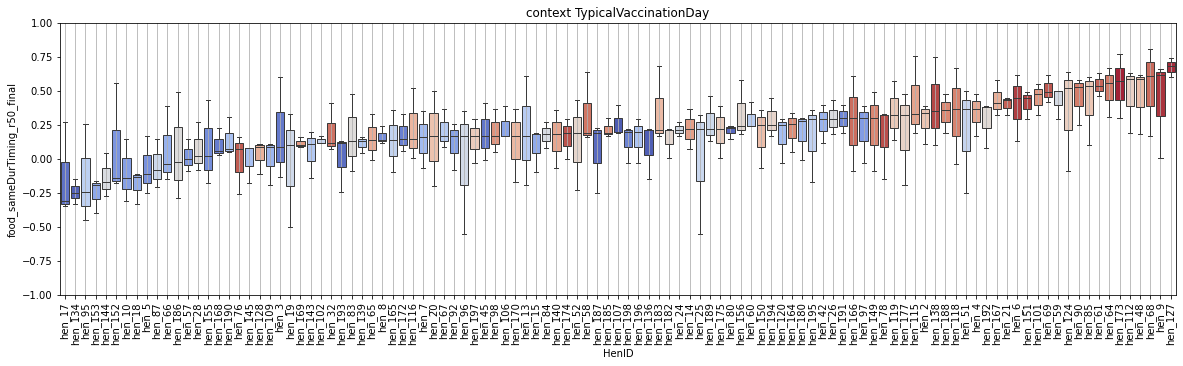

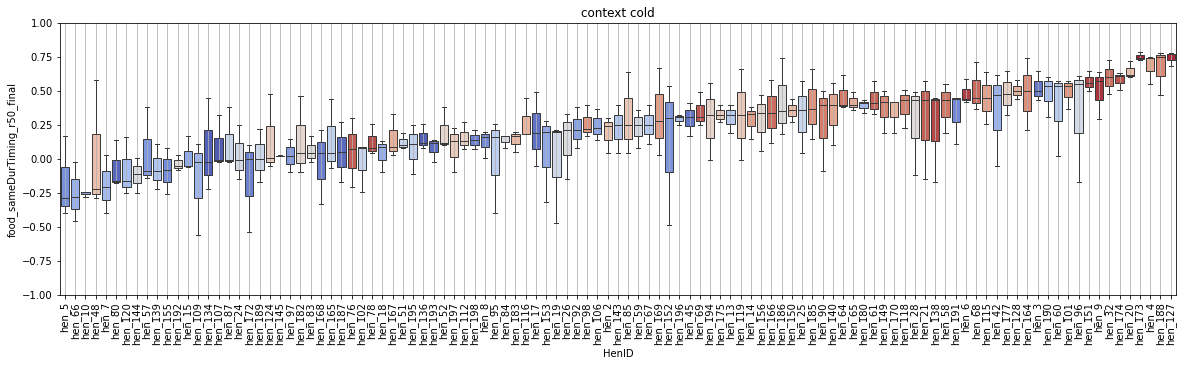

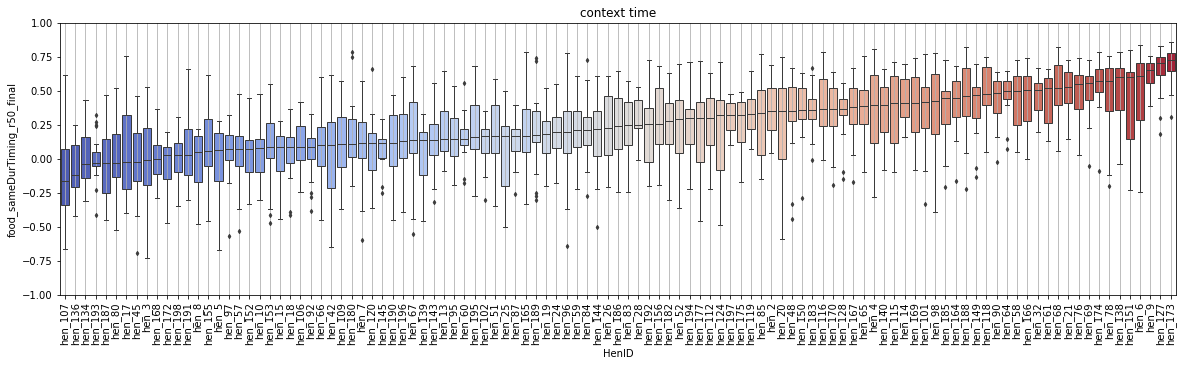

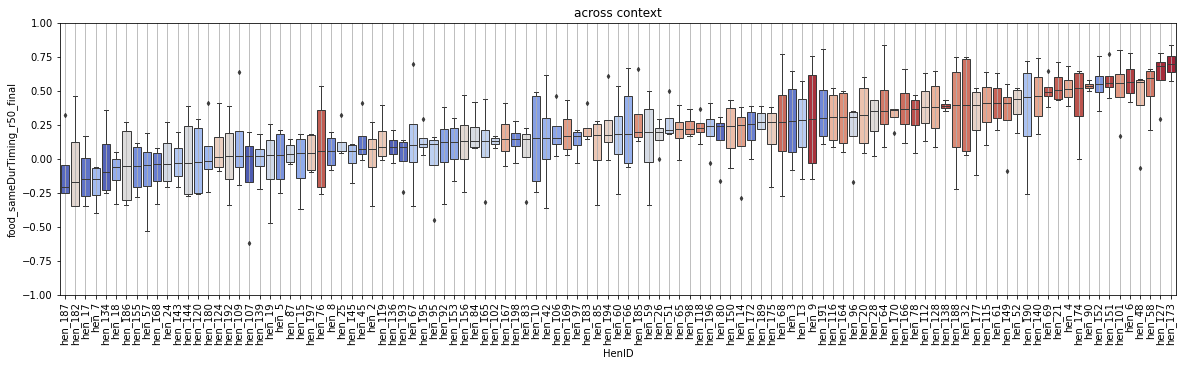

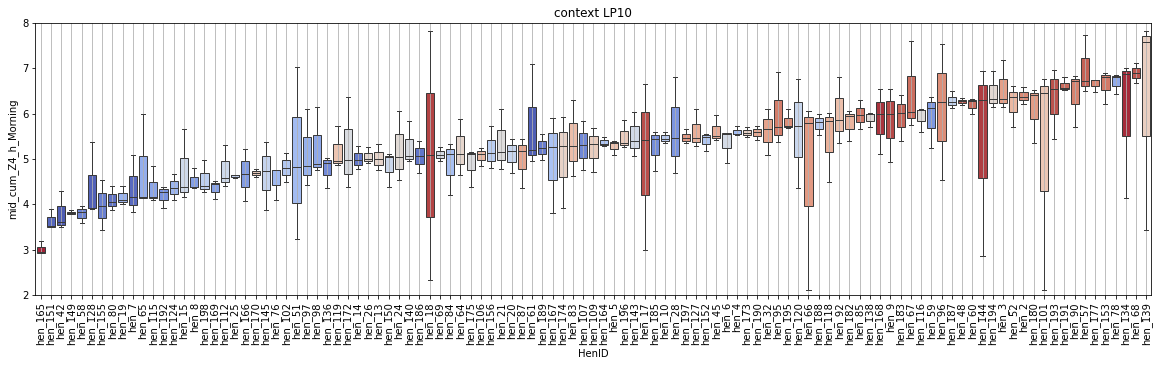

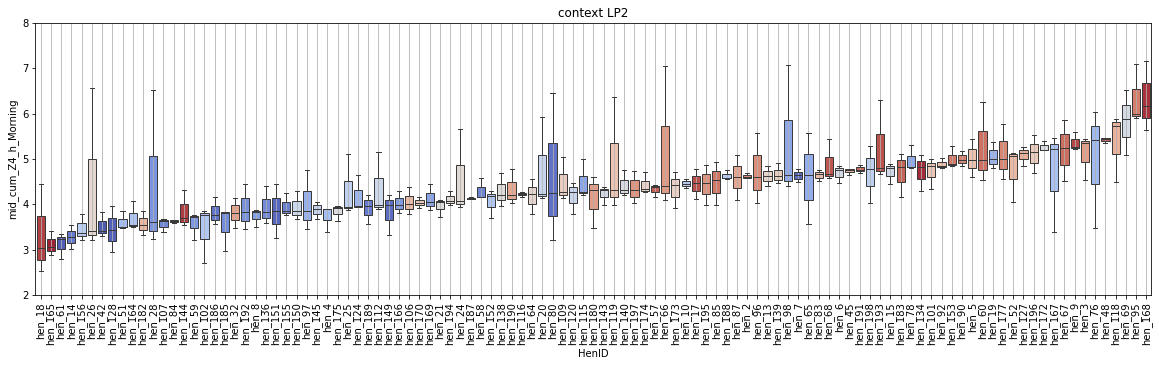

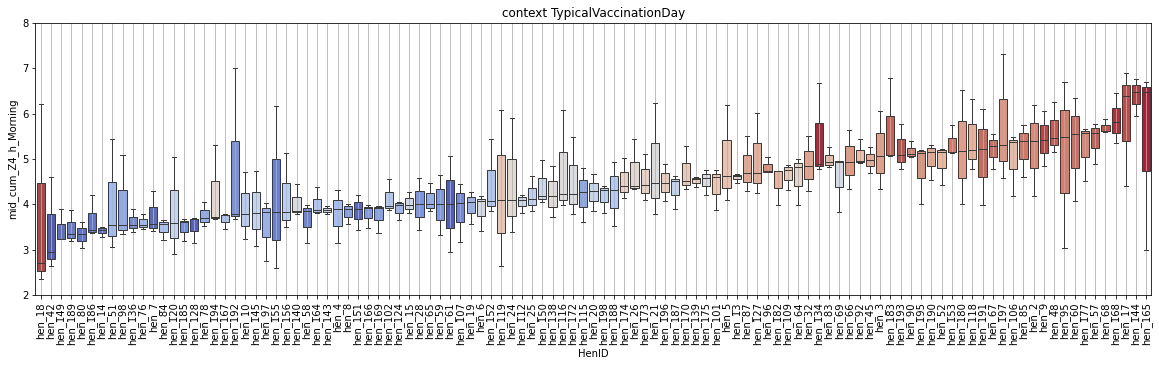

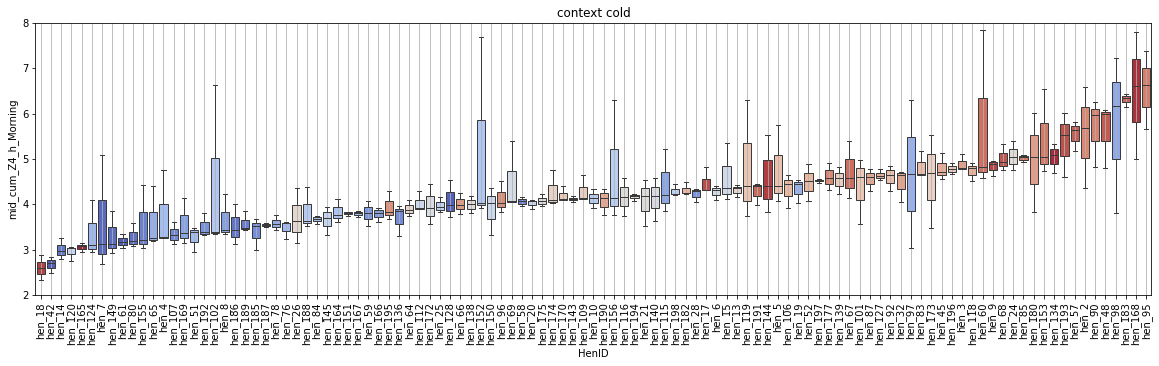

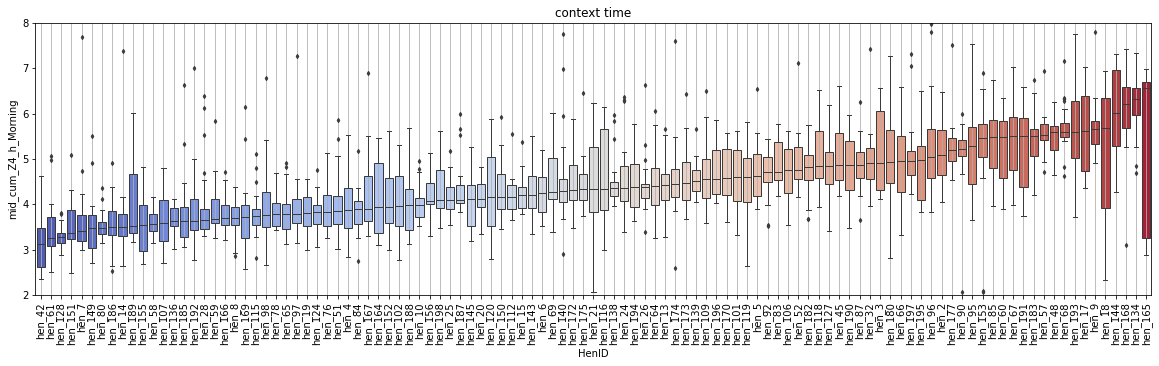

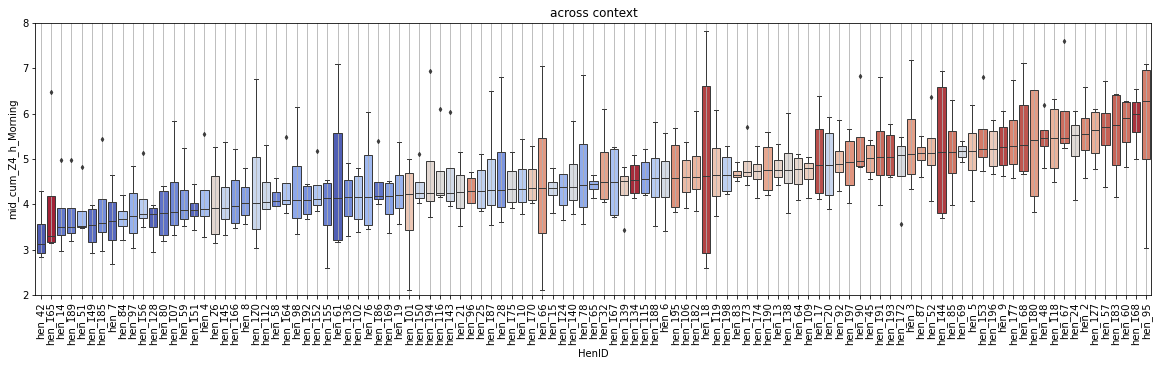

In [62]:
#dico_mvt_R = []
#'R = 0.38, 95%-CI [0.29, 0.44]'
#mvt = 'vertical_travel_distance_fulllight_perinsideh'
for mvt in li_mvt_cont:
    
    #choose color of hens based on the particular mvt variable, as sorted in the datafrmae based on the time context
    li_hen_sort = df_plt.sort_values([mvt])['HenID'].tolist()
    li_color = sns.color_palette("coolwarm",n_colors=len(df_plt['HenID'])) #flare, coolwarm,viridis
    df_plt = df_plt.sort_values(mvt)
    dico_hen_color =  dict(zip(df_plt['HenID'].tolist(), li_color))
        
    ### within context
    #for each context sort hens and plot with color as sorted by over time context
    for t, df_ in df_BS_plt.groupby(['BS_type']):
        #sort hens for that specific context based on the median to match the boxplot line
        df_plt_ = df_.groupby(['HenID'])[mvt].median().reset_index()
        li_hen_sort_ = df_plt_.sort_values([mvt])['HenID'].tolist()
        df_['sorted'] = df_['HenID'].map(lambda x: li_hen_sort_.index(x))
        df_ = df_.sort_values('sorted')
        plt.figure(figsize=(20,5))
        #plt.text(2, 10.6, 'R = 0.38, 95%-CI [0.29, 0.44]', color='black', size='x-large')
        plt.grid()
        ax = sns.boxplot(x='HenID', y=mvt, data=df_, color='grey', palette=dico_hen_color, fliersize=3, linewidth=1);
        plt.grid()
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90);
        plt.title('context '+t)
        plt.ylim((math.floor(df_BS_plt[mvt].min()),math.ceil(df_BS_plt[mvt].max())))
        plt.savefig(os.path.join(path_extracted_data ,'BS_'+mvt+'_'+t+'.png'), bbox_inches='tight')
        plt.show();

    ### across context
    df_ = df_BS_plt[df_BS_plt['across_context']==1].copy()
    df_plt_ = df_.groupby(['HenID'])[mvt].median().reset_index()
    li_hen_sort_ = df_plt_.sort_values([mvt])['HenID'].tolist()
    df_['sorted'] = df_['HenID'].map(lambda x: li_hen_sort_.index(x))
    df_ = df_.sort_values('sorted')
    plt.figure(figsize=(20,5))
    #plt.text(2, 10.6, 'R = 0.38, 95%-CI [0.29, 0.44]', color='black', size='x-large')
    plt.grid()
    ax = sns.boxplot(x='HenID', y=mvt, data=df_, color='grey', palette=dico_hen_color, fliersize=3, linewidth=1);
    plt.grid()
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90);
    plt.title('across context')
    plt.ylim((math.floor(df_BS_plt[mvt].min()),math.ceil(df_BS_plt[mvt].max())))
    plt.savefig(os.path.join(path_extracted_data ,'BS_'+mvt+'_acrosscontext.png'), bbox_inches='tight')
    plt.show();

#### Binary mvt var

In [63]:
#dataframe to be able to sort hens by mean behavior over the time context only
df_plt_binary = df_BS_plt[df_BS_plt['BS_type']=='time'].groupby(['HenID'])[li_mvt_bin].mean().reset_index()
df_plt_binary['Sleeping_Uppest_perc'] = df_plt_binary['Sleeping_Uppest'].map(lambda x: x*100)
print(df_plt_binary.shape)
df_plt_binary.head(3)

(109, 4)


,HenID,WentinWG,Sleeping_Uppest,Sleeping_Uppest_perc
0,hen_10,0.333333,0.047619,4.761905
1,hen_101,0.952381,0.428571,42.857143
2,hen_102,1.000000,1.000000,100.000000


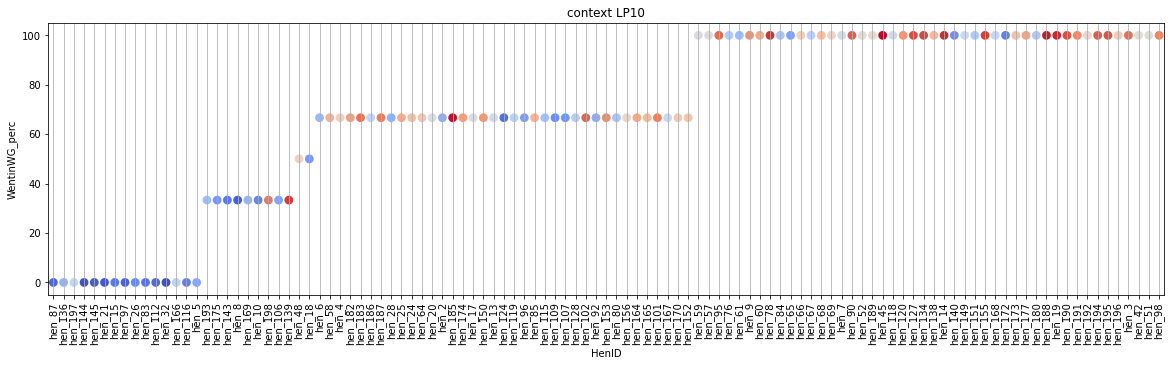

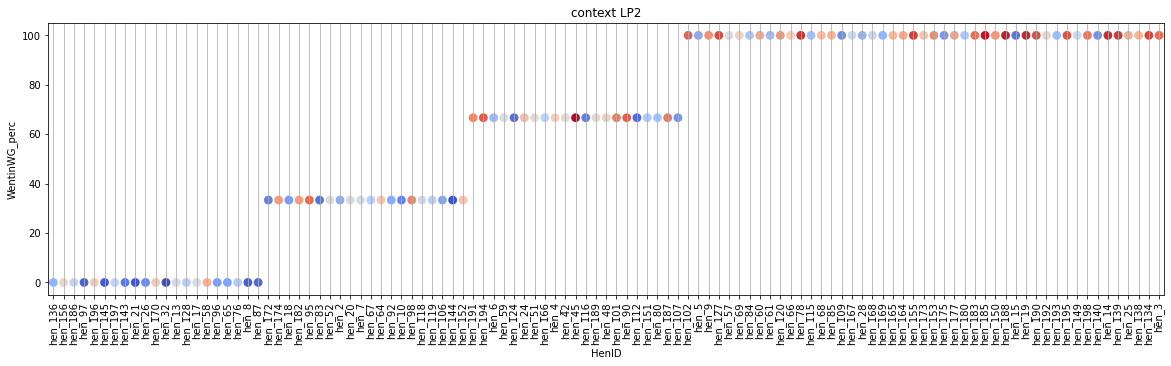

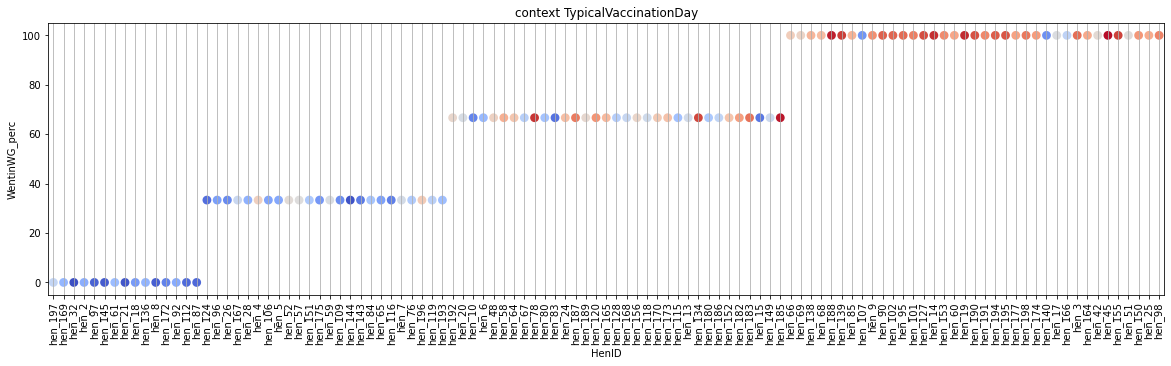

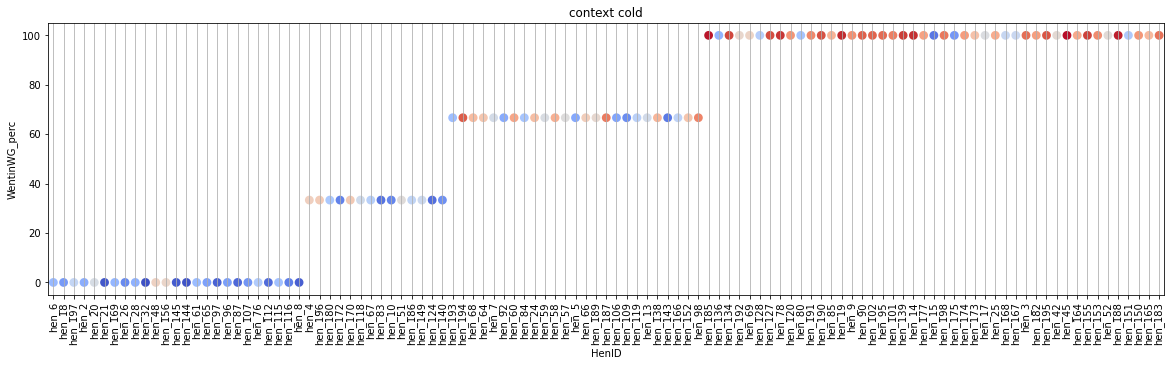

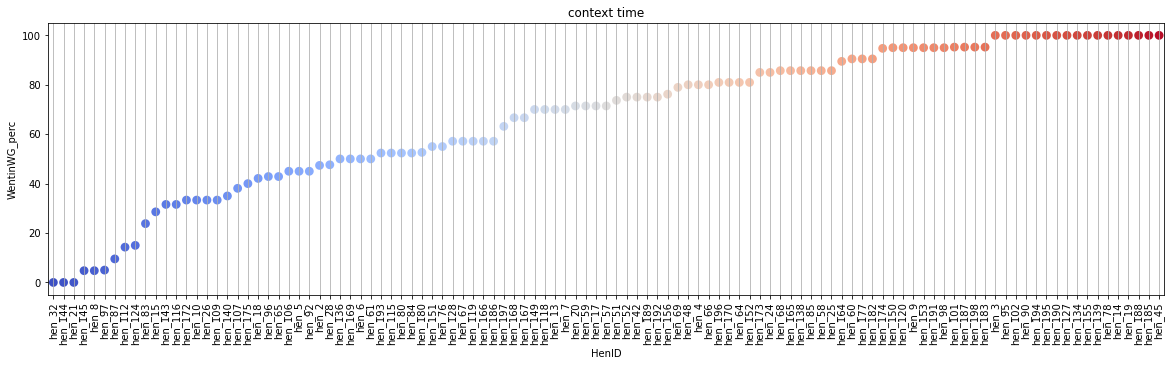

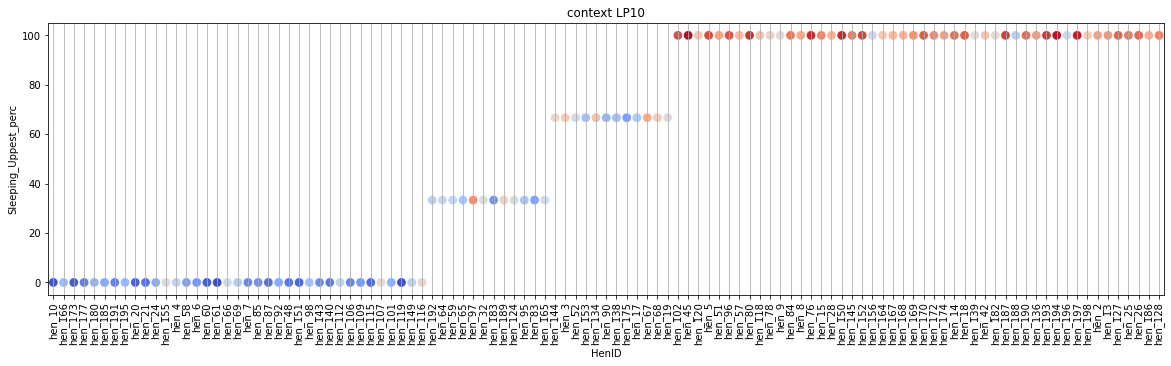

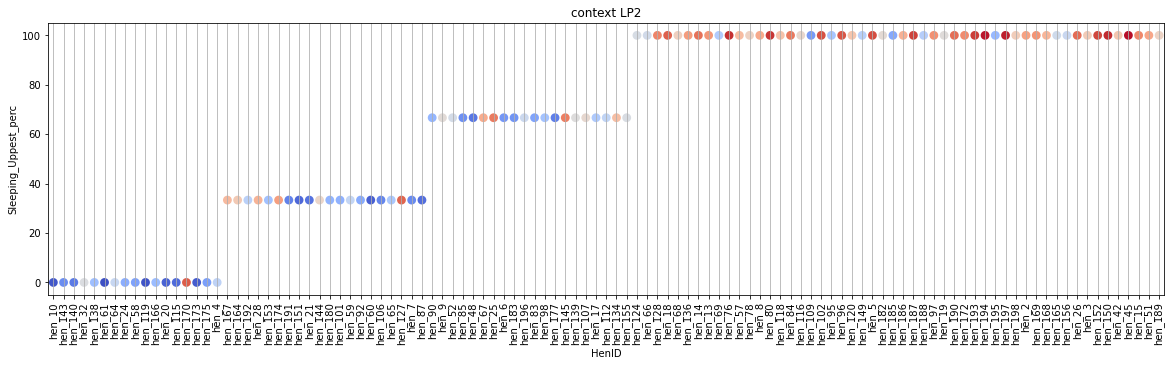

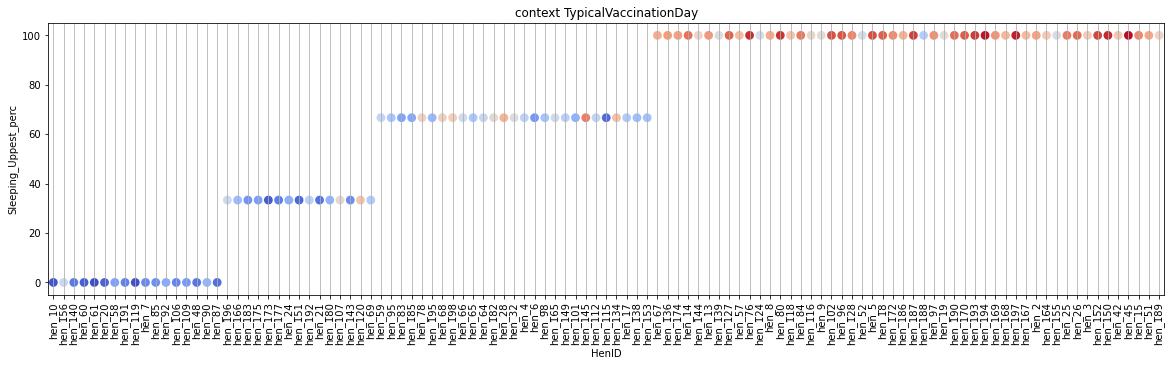

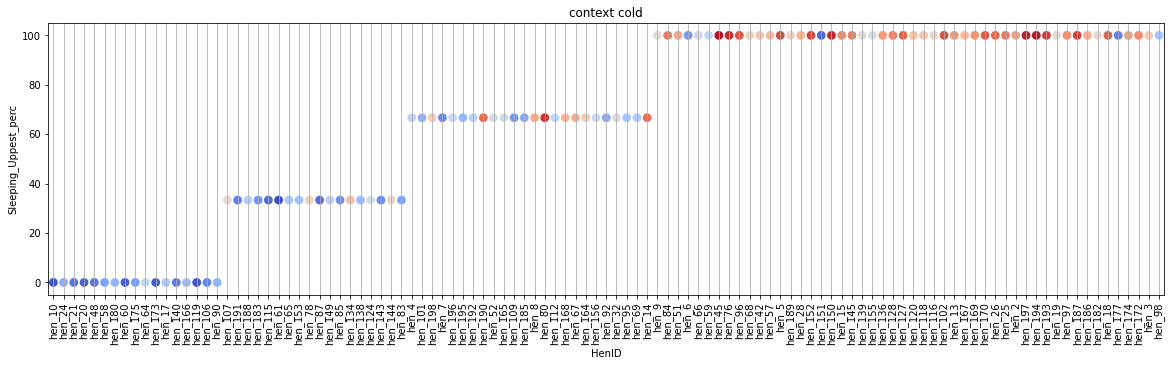

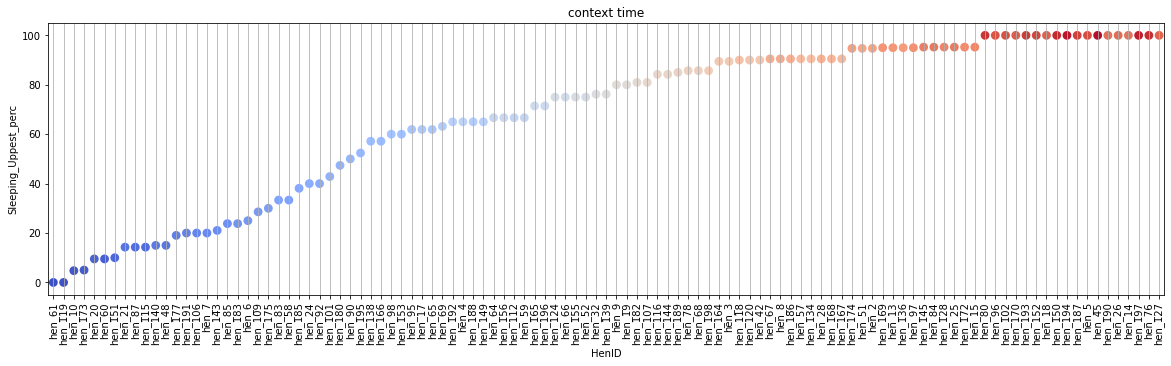

In [64]:
#dico_mvt_R = []
#'R = 0.38, 95%-CI [0.29, 0.44]'
#mvt = 'vertical_travel_distance_fulllight_perinsideh'
for mvt in li_mvt_bin:
    
    #choose color of hens based on the particular mvt variable, as sorted in the dataframe based on the time context
    li_hen_sort = df_plt_binary.sort_values([mvt])['HenID'].tolist()
    li_color = sns.color_palette("coolwarm",n_colors=len(df_plt_binary['HenID'])) #flare, coolwarm,viridis
    df_plt_binary = df_plt_binary.sort_values(mvt)
    dico_hen_color =  dict(zip(df_plt_binary['HenID'].tolist(), li_color))
    
    #for each context sort hens and plot with color as sorted by over time context
    for t, df_ in df_BS_plt.groupby(['BS_type']):
        #sort hens for that specific context
        df_plt_ = df_.groupby(['HenID'])[mvt].mean().reset_index()
        df_plt_[mvt+'_perc'] = df_plt_[mvt].map(lambda x: x*100)
        df_plt_ = df_plt_.sort_values([mvt+'_perc'])
        plt.figure(figsize=(20,5))
        #plt.text(2, 10.6, 'R = 0.38, 95%-CI [0.29, 0.44]', color='black', size='x-large')
        plt.grid()
        ax = sns.pointplot(x='HenID', y=mvt+'_perc', data=df_plt_, color='grey', palette=dico_hen_color);
        plt.grid()
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90);
        plt.title('context '+t)
        plt.savefig(os.path.join(path_extracted_data ,'BS_'+mvt+'_'+t+'.png'), bbox_inches='tight')
        plt.show();

# Available data - Visually

#heatmap of the hens, one row per hen: 1 means existing tracked day for the hen
df_plt = df_daily[['HenID', 'PenID', 'Treatment', 'CLASS','level','duration_5_Zone_min']].copy()
#dico_cl = {'EPI':'unknown', 'LEXP':'LEXP', 'MEXP':'MEXP', 'LEXPLOST':'unknown', 'MEXPLOST':'unknown','NewAfterEpi':'unknown', #'NewAfterEpiLOST':'unknown'}
#df_plt['CLASS'] = df_plt['CLASS'].map(lambda x: dico_cl[x])

#####find missing days
Daterange = pd.date_range(start = df_daily['level'].min(), end = df_daily['level'].max(), freq = 'D')    
li_missing_dates = [i for i in Daterange if i not in df_plt['level'].unique()]

#####add one row per missing dates for a random hen with duration_5_Zone_min beeing np.nan
x = df_plt.iloc[0]
df_missingdate = pd.DataFrame([{'level':d, 'duration_5_Zone_min':np.nan, 'HenID':x['HenID'], 'PenID':x['PenID'], 
                                'Treatment':x['Treatment'],'CLASS':x['CLASS']} for d in li_missing_dates])
print(df_plt.shape)
df_plt = df_plt.append(df_missingdate, ignore_index=True)
print(df_plt.shape)
df_plt['level'] = df_plt['level'].map(lambda x: dt.datetime.date(x))
df_plt.sort_values(['level'], inplace=True)
li_date = df_plt['level'].unique()

#####say if bird was tracked on taht day or not (i.e. we have his duration in zone 5)
df_plt['Tracked'] = df_plt['duration_5_Zone_min'].map(lambda x: int(not math.isnan(x)))
display(df_plt.head(3))
df_plt = df_plt.pivot(index=['HenID', 'PenID', 'Treatment', 'CLASS'], columns='level', values='Tracked').reset_index()
df_plt = df_plt.fillna(0)
df_plt.sort_values(['PenID'], inplace=True)
li_henorder = df_plt['HenID'].tolist()
print(df_plt.shape)
df_plt.head(3)

#per hens
fig = plt.figure(figsize=(15,30))
sns.heatmap(df_plt[li_date].to_numpy(), xticklabels=li_date,  yticklabels=df_plt['HenID'].tolist(), cmap="YlGnBu")
plt.title('Available data per treatment')
plt.savefig(os.path.join(path_extracted_data_chapter2,'DataPerHens.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

#per treatment
df_plt_summarized = df_plt.groupby(['Treatment','PenID'])[li_date].sum().reset_index()
df_plt_summarized['name'] = df_plt_summarized.apply(lambda x: x['Treatment']+' - Pen '+str(x['PenID']), axis=1)
fig = plt.figure(figsize=(20,3))
sns.heatmap(df_plt_summarized[li_date].to_numpy(), xticklabels=li_date, 
            yticklabels=df_plt_summarized['name'].tolist(), cmap="YlGnBu", annot=True)
plt.title('Available data per treatment')
plt.savefig(os.path.join(path_extracted_data_chapter2,'DataPerTreatment.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

#per class
df_plt_summarized = df_plt.groupby(['CLASS','Treatment','PenID'])[li_date].sum().reset_index()
df_plt_summarized['name'] = df_plt_summarized.apply(lambda x: x['CLASS']+' - '+x['Treatment']+' - Pen '+str(x['PenID']), 
                                                    axis=1)
fig = plt.figure(figsize=(20,8))
sns.heatmap(df_plt_summarized[li_date].to_numpy(), xticklabels=li_date, 
            yticklabels=df_plt_summarized['name'].tolist(), cmap="YlGnBu", annot=True)
plt.title('Available data per class')
plt.savefig(os.path.join(path_extracted_data_chapter2,'DataPerClass.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()